# Counting on Poisson Regression

## Loading Data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from threadpoolctl import threadpool_limits
import matplotlib

In [2]:
from pathlib import Path
# Set to True to export images
EXPORT_IMAGES = False
images = Path("images")

In [3]:
threadpool_limits(limits=1, user_api="openmp")

In [4]:
data_path = Path("data")
bikes_path = data_path / "london_bikes.csv"

In [5]:
bikes = pd.read_csv(bikes_path)

In [6]:
print(bikes.head(8).to_markdown(index=False))

|   cnt |   t1 |   hum |   wind_speed |   weather_code |   is_holiday |   is_weekend |   season |   hour |
|------:|-----:|------:|-------------:|---------------:|-------------:|-------------:|---------:|-------:|
|   182 |  3   |  93   |          6   |              3 |            0 |            1 |        3 |      0 |
|   138 |  3   |  93   |          5   |              1 |            0 |            1 |        3 |      1 |
|   134 |  2.5 |  96.5 |          0   |              1 |            0 |            1 |        3 |      2 |
|    72 |  2   | 100   |          0   |              1 |            0 |            1 |        3 |      3 |
|    47 |  2   |  93   |          6.5 |              1 |            0 |            1 |        3 |      4 |
|    46 |  2   |  93   |          4   |              1 |            0 |            1 |        3 |      5 |
|    51 |  1   | 100   |          7   |              4 |            0 |            1 |        3 |      6 |
|    75 |  1   | 100   |          7  

In [7]:
# These X and y values will be used as globals so the plot calls are simplier
X = bikes.drop("cnt", axis=1)
y = bikes["cnt"]

In [8]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(
    n_splits=50,
    max_train_size=10000,
    test_size=336,
)

In [9]:
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit

def custom_metric(est, X, y):
    y_pred = est.predict(X)
    mask = y_pred > 0
    return {
        "mean_possion_devianace": mean_poisson_deviance(y[mask], y_pred[mask]),
        "root_mean_squared_error": mean_squared_error(y, y_pred, squared=False),
    }

We get the splits used by `cross_validate` to get predictions on the test sets:

In [10]:
X_tests = []
y_tests = []

for train_idx, test_idx in cv.split(X):
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_tests.append(X_test)
    y_tests.append(y_test)
    
y_test = np.concatenate(y_tests)

In [11]:
def evaluate_model(est, model, n_jobs=1):
    results = cross_validate(est, X, y, scoring=custom_metric, cv=cv, n_jobs=n_jobs, return_estimator=True)
    output = {"model": model}
    for key, values in results.items():
        if key == "estimator":
            continue
        key_name = key[5:]
        output[key_name] = results[key]
        output[f"{key_name}_mean"] = results[key].mean()
    output["estimator"] = results["estimator"]
    return output

In [12]:
def get_predictions_all_splits(results):
    y_preds = [
        est.predict(X_test)
        for est, X_test in zip(results["estimator"], X_tests)
    ]
    results["test_predictions"] =  np.concatenate(y_preds)

## Linear Model

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import make_column_selector

In [14]:
categorical = ["is_holiday", "weather_code", "is_weekend", "season"]

preprocessor = ColumnTransformer([
    ("cyclic_hour", SplineTransformer(n_knots=13, extrapolation="periodic"), ["hour"]),
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical),
], remainder=MinMaxScaler())

In [15]:
preprocessor

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('cyclic_hour',
                                 SplineTransformer(extrapolation='periodic',
                                                   n_knots=13),
                                 ['hour']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['is_holiday', 'weather_code', 'is_weekend',
                                  'season'])])

## PoissonRegressor

In [16]:
poisson = make_pipeline(preprocessor, PoissonRegressor(max_iter=300))

In [17]:
poisson

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('cyclic_hour',
                                                  SplineTransformer(extrapolation='periodic',
                                                                    n_knots=13),
                                                  ['hour']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['is_holiday', 'weather_code',
                                                   'is_weekend', 'season'])])),
                ('poissonregressor', PoissonRegressor(max_iter=300))])

In [18]:
poisson_results = evaluate_model(poisson, "Poisson", n_jobs=8)

In [19]:
poisson_results["mean_possion_devianace"].mean()

193.43627302255481

In [20]:
poisson_results["mean_possion_devianace"].mean()

193.43627302255481

In [21]:
get_predictions_all_splits(poisson_results)

## Ridge

In [22]:
from sklearn.linear_model import Ridge
ridge = make_pipeline(
    preprocessor,
    Ridge()
)

In [23]:
ridge_results = evaluate_model(ridge,  "Ridge", n_jobs=8)

In [24]:
ridge_results["mean_possion_devianace_mean"]

274.0353425298722

In [25]:
get_predictions_all_splits(ridge_results)

In [26]:
def plot_results(*results):
    metrics = ["root_mean_squared_error", "mean_possion_devianace"]
    title = ["Root Mean Squared Error", "Mean Possion Deviance"]
    fig, axes = plt.subplots(1, len(metrics), figsize=(10, 4), sharey=True, dpi=300, constrained_layout=True)
    for i, metric in enumerate(metrics):
        dfs = [pd.DataFrame({
            metric: result[metric],
            "model": result["model"],
        }) for result in results]
        df_all = pd.concat(dfs)
    
        ax = axes[i]
        sns.swarmplot(y="model", x=metric, data=df_all, ax=ax, color=".25")
        sns.boxplot(y="model", x=metric, data=df_all, ax=ax)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title(title[i], fontsize=18)
        ax.tick_params(axis="y", labelsize=16)
    return fig

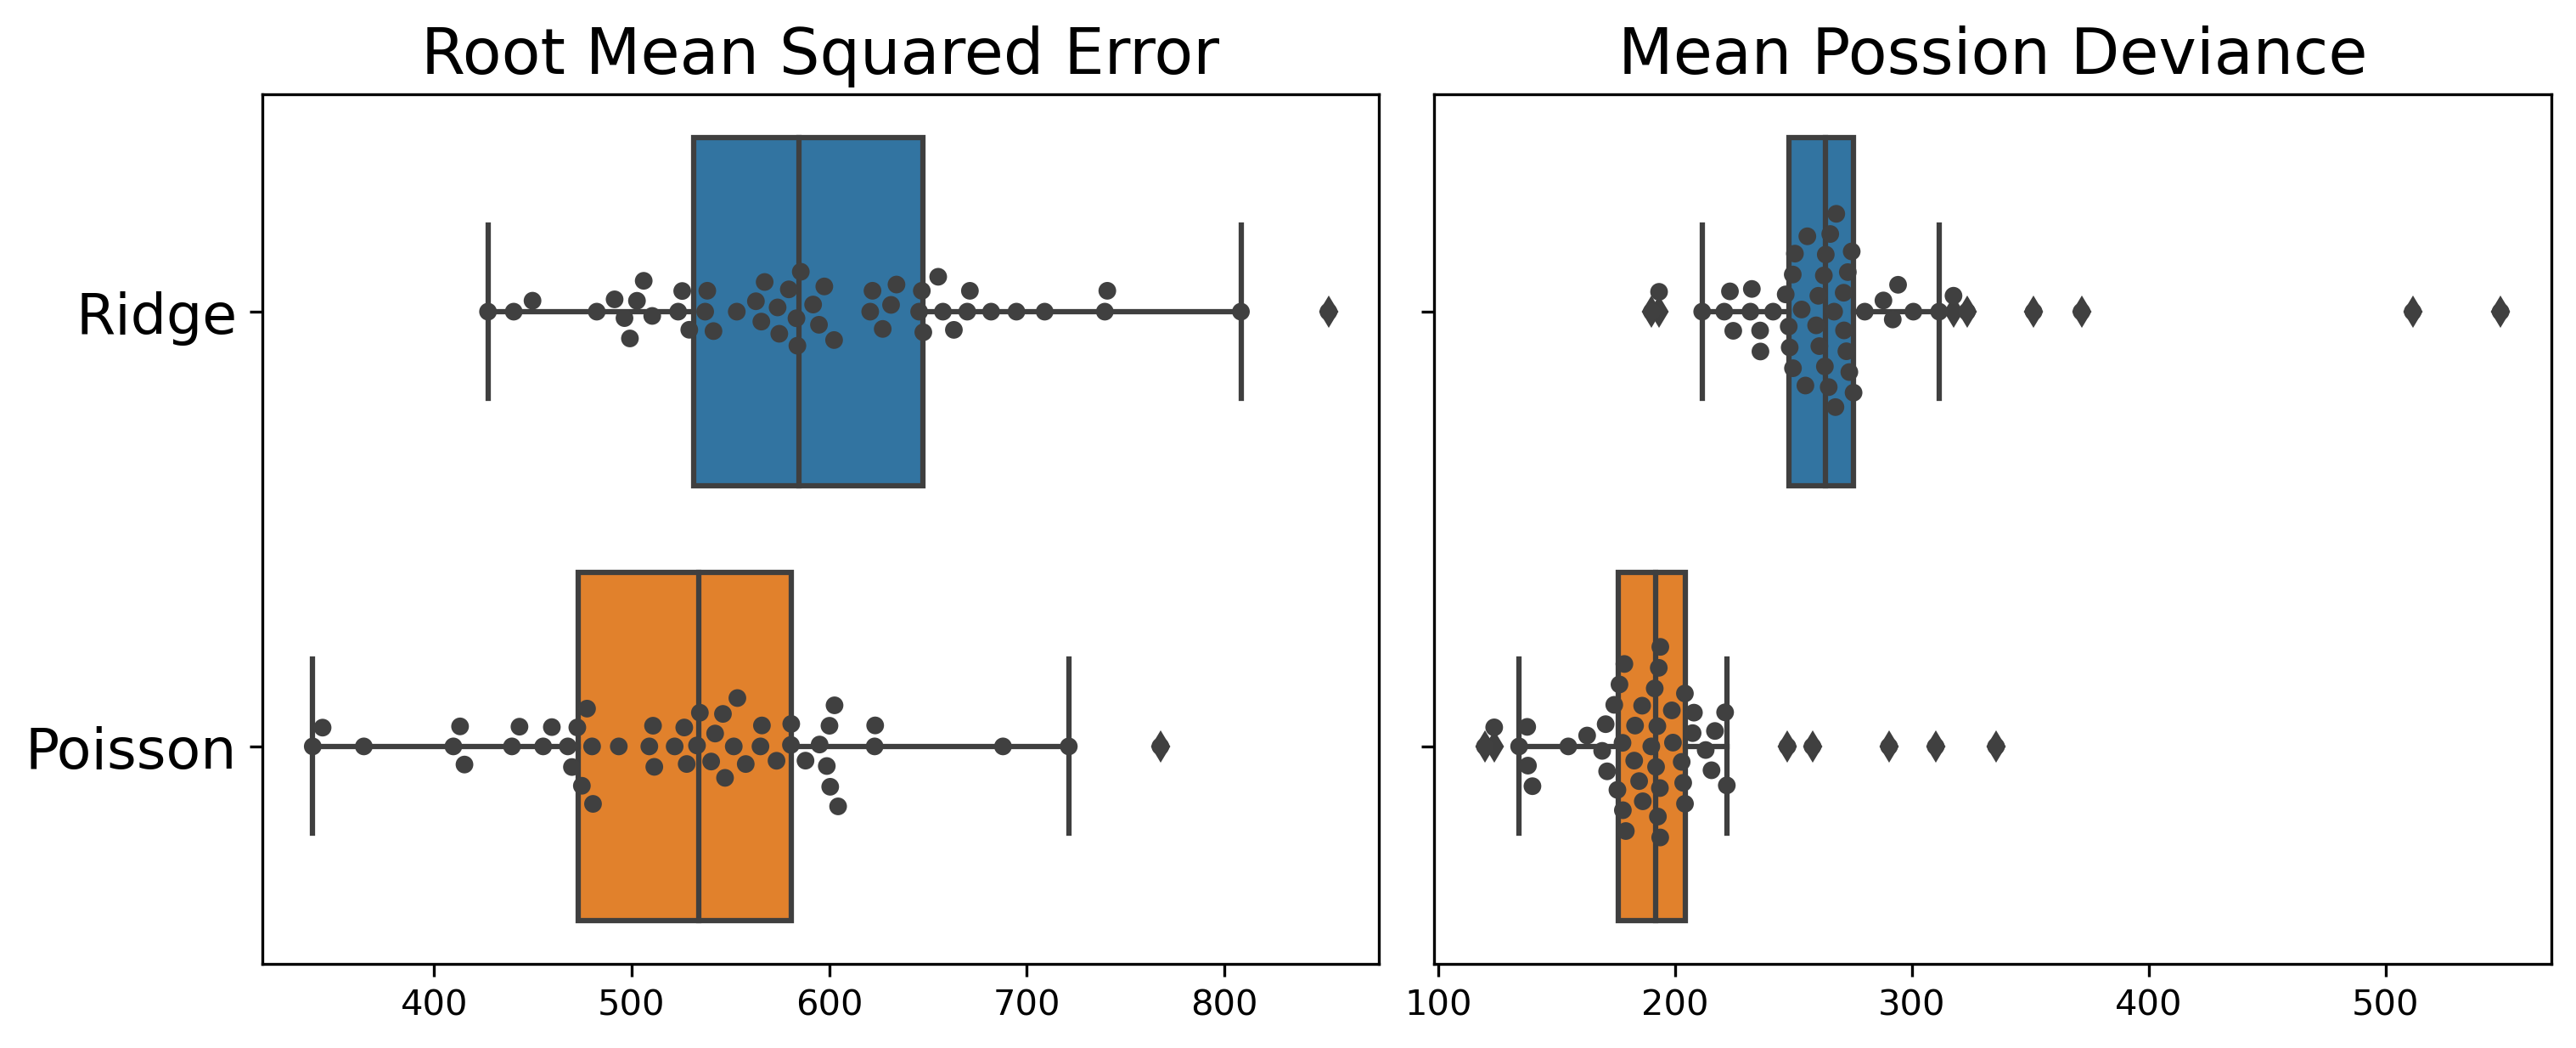

In [27]:
fig = plot_results(ridge_results, poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "ridge_poisson_metrics.svg")

In [28]:
blue = sns.color_palette()[0]
orange = sns.color_palette()[1]
purple = "#520b92"

In [29]:
def plot_distribution(results_1, results_2):
    name_1, pred_1 = results_1["model"], results_1["test_predictions"]
    name_2, pred_2 = results_2["model"], results_2["test_predictions"]
    fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True, constrained_layout=True, dpi=300)
    
    # This assumes that the predictions are made on `X_test`
    ax[0].hist(y_test, bins=25, color=purple)
    ax[0].set_title("Data", fontsize=24)
    ax[1].hist(pred_1, bins=25, color=blue)
    ax[1].set_title(name_1, fontsize=24)
    ax[2].hist(pred_2, bins=25, color=orange)
    ax[2].set_title(name_2, fontsize=24)
    
    for i in range(3):
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(12)
        for tick in ax[i].get_yticklabels():
            tick.set_fontsize(12)
    return fig

## Evaluting Linear models

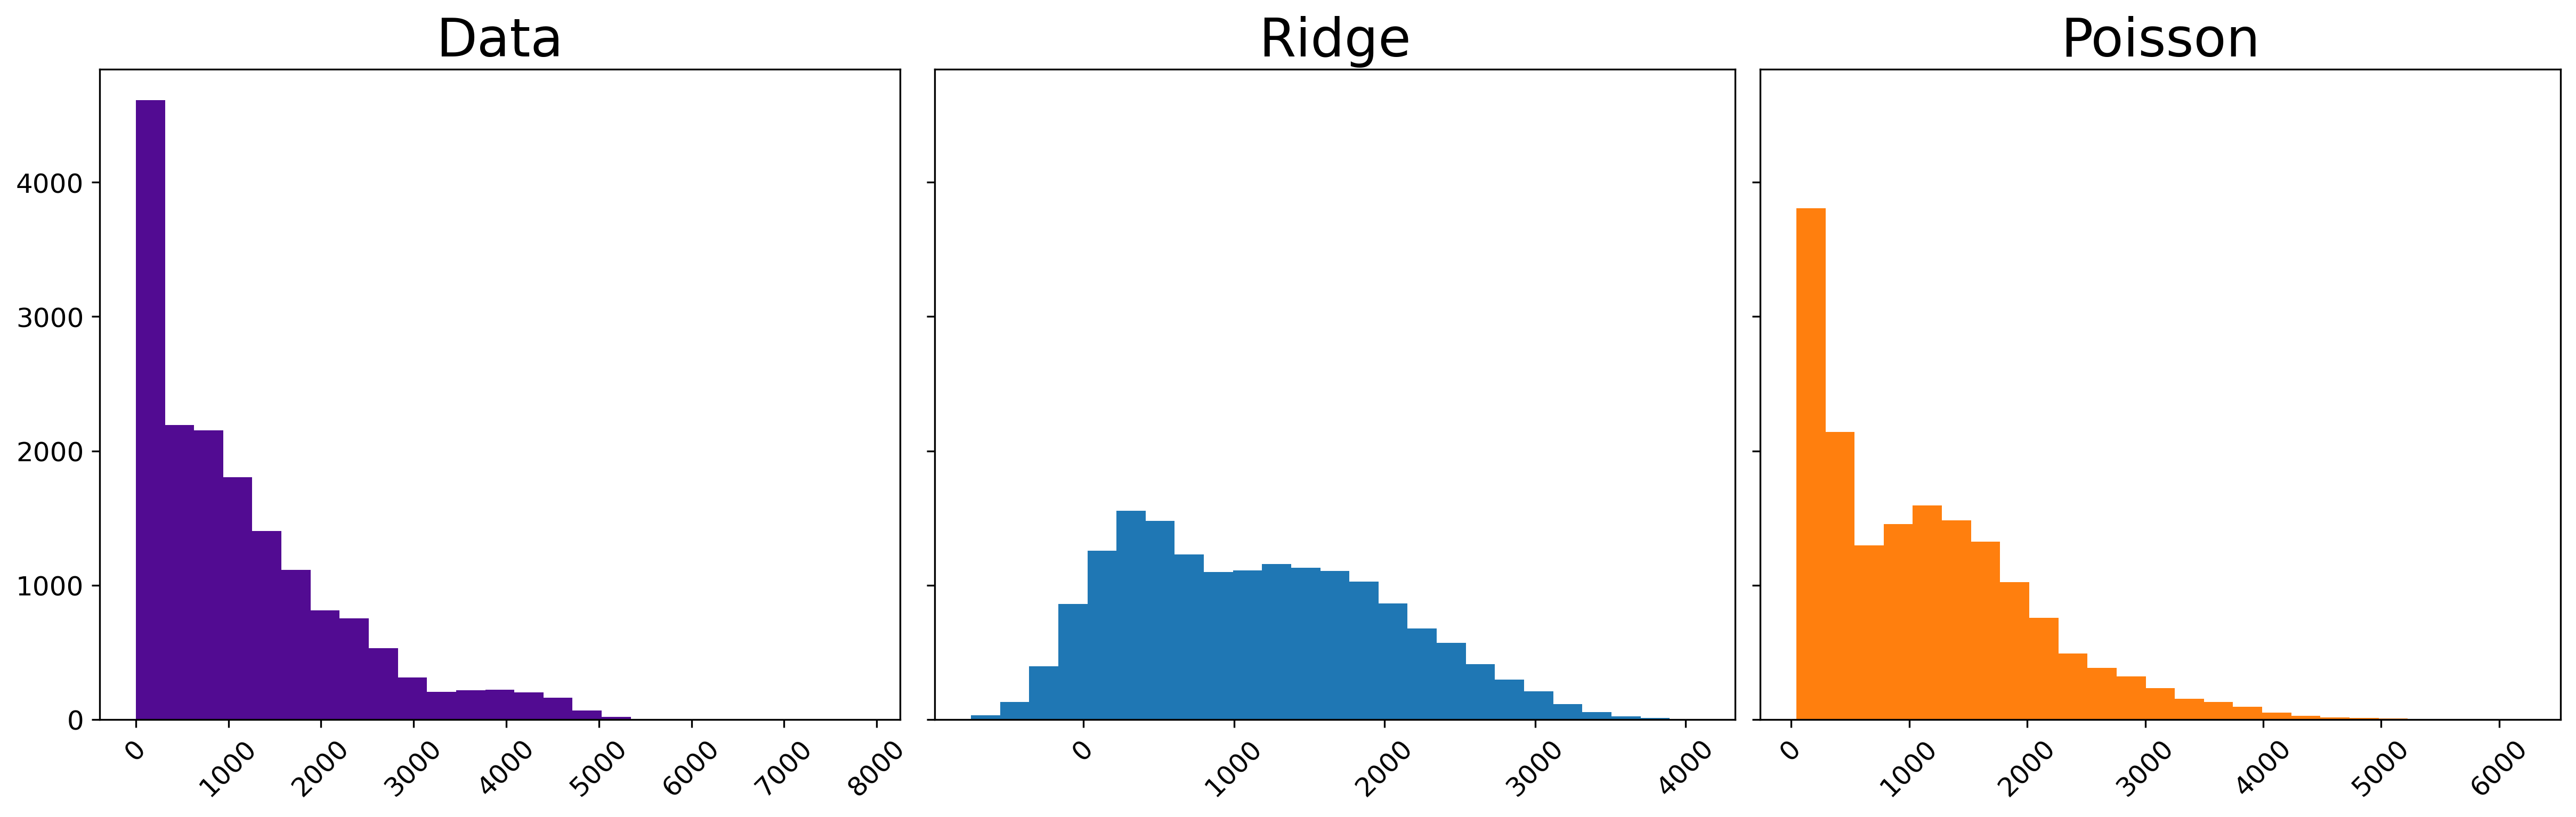

In [30]:
fig = plot_distribution(ridge_results, poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "ridge_poisson_dist.svg")

In [31]:
from sklearn.utils import gen_even_slices

def plot_single_calibration(y_true, y_pred, title, ax, color, n_bins=10):
    idx_sort = np.argsort(y_pred)
    y_true = np.asarray(y_true)
    
    y_pred_bin = np.empty(n_bins)
    y_true_bin = np.empty(n_bins)
    
    y_pred_sorted = y_pred[idx_sort]
    y_true_sorted = y_true[idx_sort]

    for i, chunk in enumerate(gen_even_slices(len(idx_sort), n_bins)):
        y_pred_bin[i] = np.mean(y_pred_sorted[chunk])
        y_true_bin[i] = np.mean(y_true_sorted[chunk])
    
    bins = np.arange(n_bins)
    ax.plot(bins, y_pred_bin - y_true_bin, marker="o", linestyle="-", color=color)
    ax.axhline(y=0, ls="--", color="black")
    for tick in ax.get_xticklabels():
        tick.set_fontsize(16)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(16)
        
    ax.set_title(f"{title}", fontsize=20)
    ax.set_xlabel("Bin", fontsize=16)
    _ = ax.set_xticks(bins)
    
def plot_calibration(results_1, results_2, n_bins=10):
    name_1, pred_1 = results_1["model"], results_1["test_predictions"]
    name_2, pred_2 = results_2["model"], results_2["test_predictions"]
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5), dpi=300, sharey=True)
    plot_single_calibration(y_test, pred_1, name_1, ax=ax[0], color=blue)
    plot_single_calibration(y_test, pred_2, name_2, ax=ax[1], color=orange)
    ax[0].set_ylabel("$E(\hat{y}) - E(y)$", fontsize=16)
    return fig

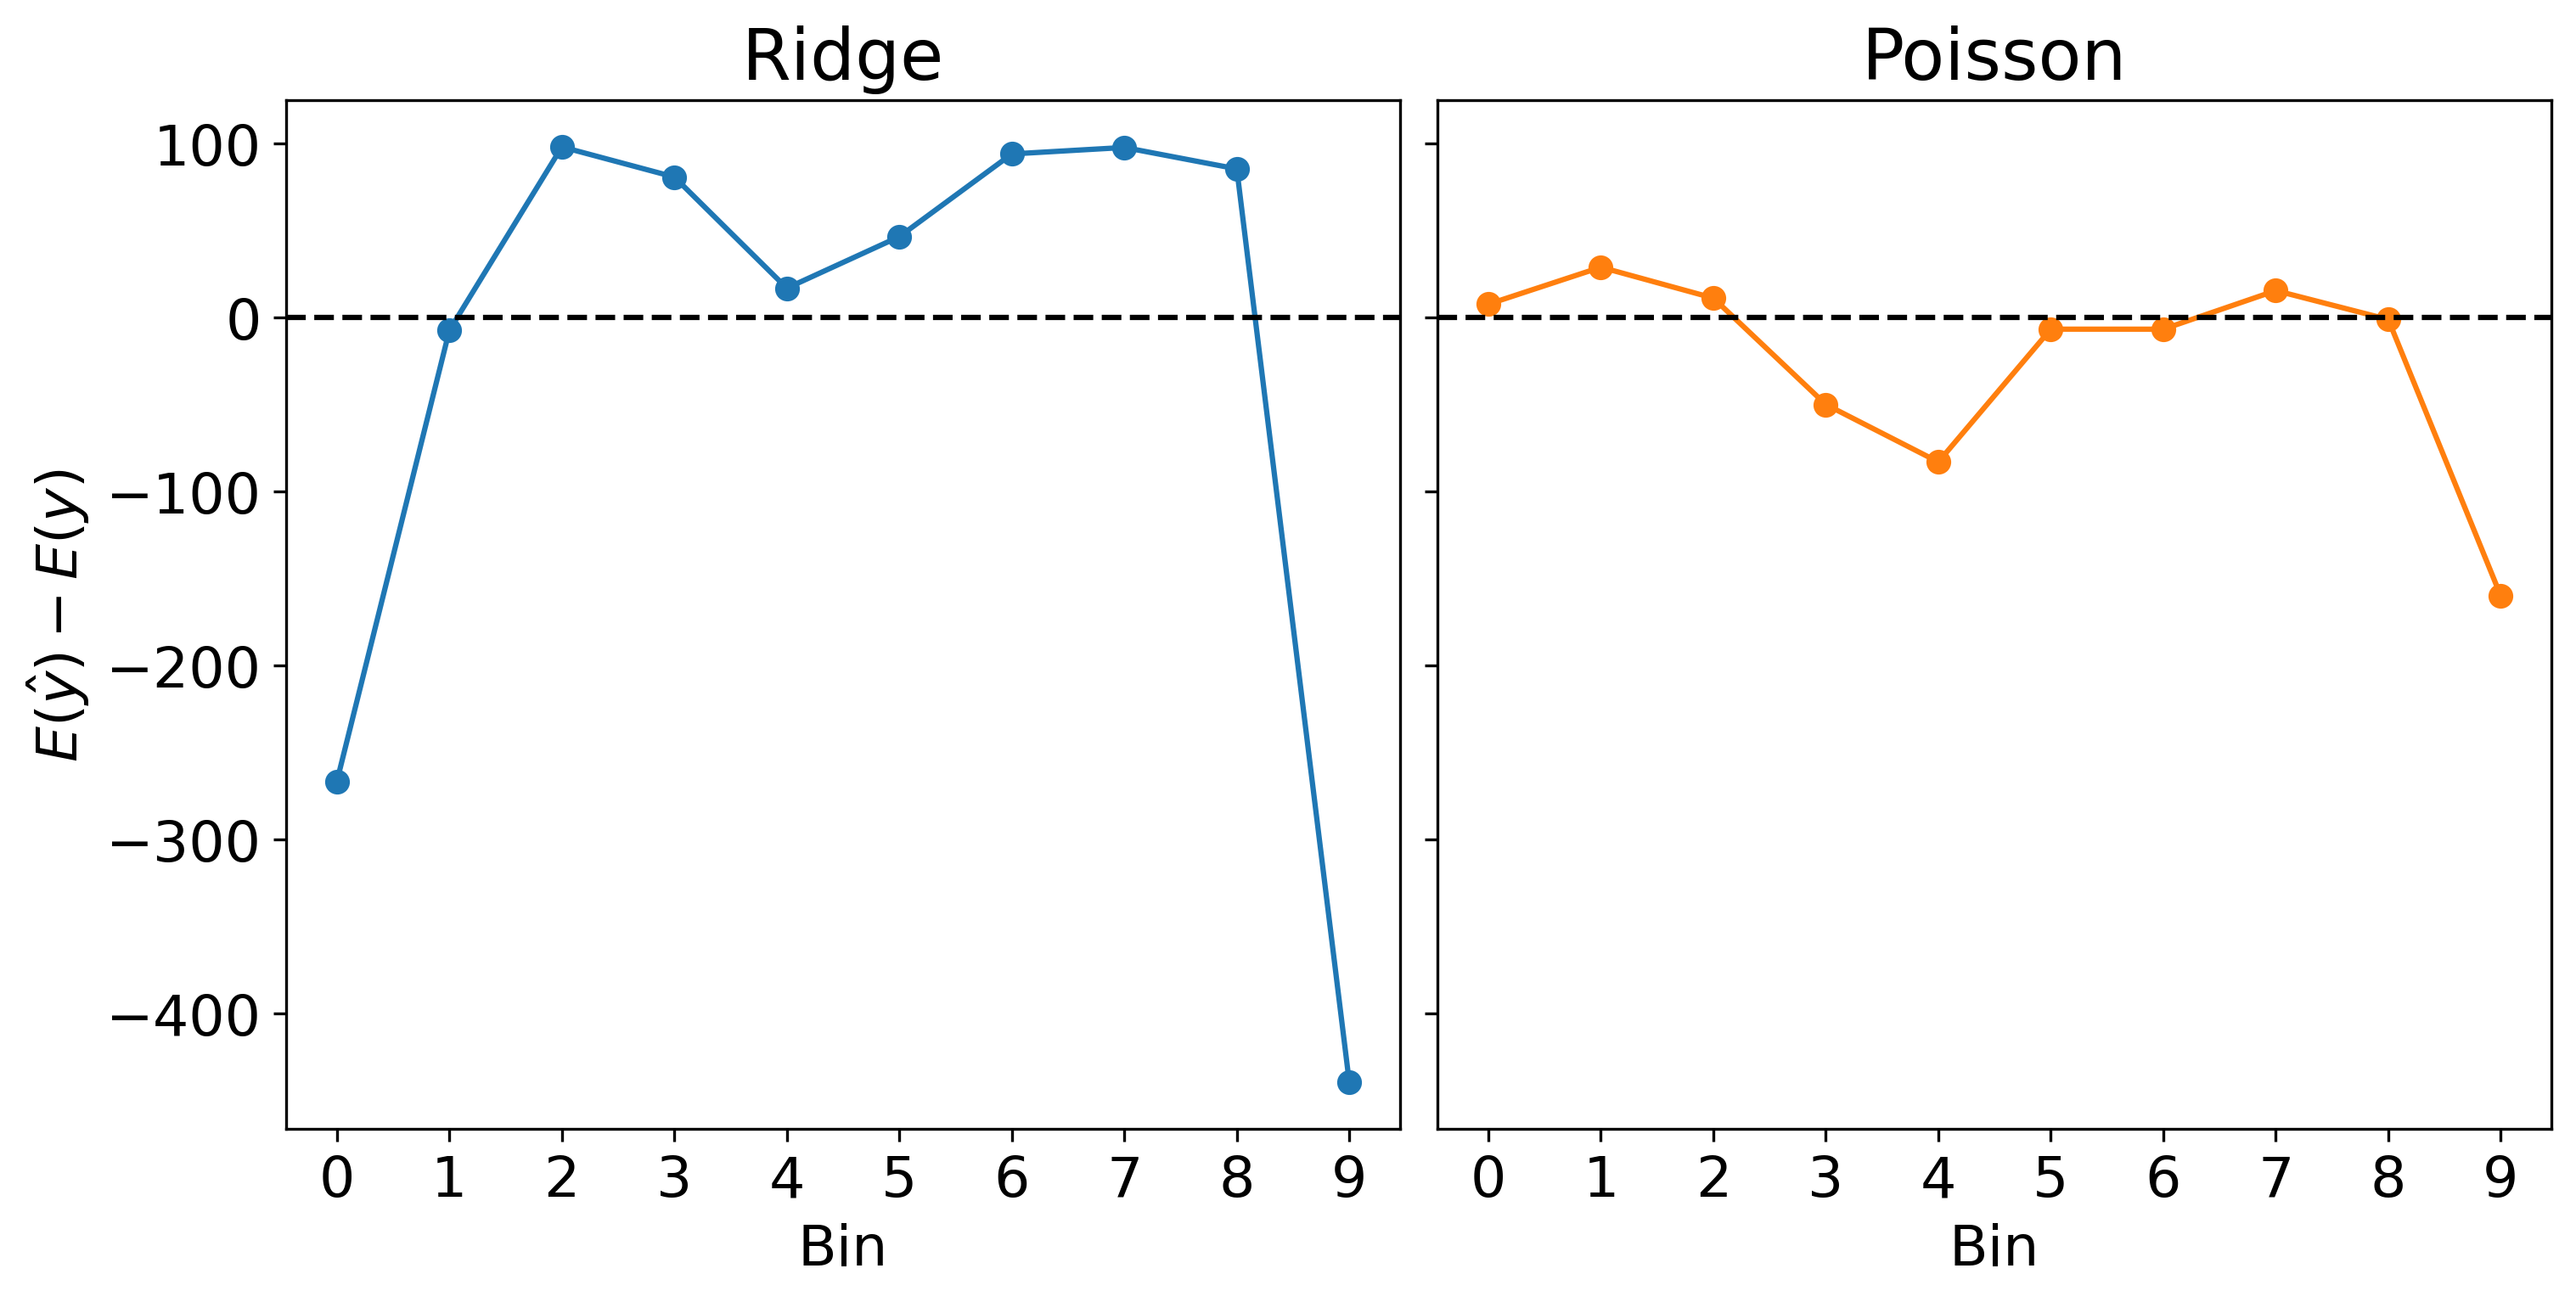

In [32]:
fig = plot_calibration(ridge_results, poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "ridge_poisson_calib.svg")

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rf = RandomForestRegressor(n_jobs=1, random_state=0, min_samples_leaf=40)

In [35]:
rf_results = evaluate_model(rf, "Forest (mean squared error)", n_jobs=8)

In [36]:
rf_results["mean_possion_devianace"]

array([182.94795759, 174.67077345, 188.48213889, 113.20807704,
       209.87379886, 172.83808735, 133.6134786 , 142.85336838,
       142.07413228, 115.41445789, 138.46416281, 289.20354983,
       163.44979429, 187.77514103, 166.59820659, 135.6605197 ,
        76.31570161,  92.60317073,  54.63991009,  79.25870017,
        78.21311887,  82.27213736,  57.41041707, 449.51466525,
        59.6940778 ,  36.87659997,  32.70742266,  30.51965735,
        41.60706117,  82.83185438,  97.17307122,  57.74335022,
        78.74829592,  59.57578707,  98.72135497,  79.34662745,
        66.25115982,  51.25526248,  71.08165982,  67.87484691,
        99.94248542, 109.0560115 ,  58.12729145,  57.08428489,
        59.58286865,  55.49862602,  48.17243546,  30.94675541,
        45.79533025, 394.58240365])

In [37]:
rf_results["mean_possion_devianace_mean"]

111.9630409524596

In [38]:
get_predictions_all_splits(rf_results)

## Random Forest Poisson

In [39]:
rf_poisson = RandomForestRegressor(criterion="poisson", random_state=0, min_samples_split=40)

In [40]:
rf_poisson_results = evaluate_model(rf_poisson,"Forest (poisson)", n_jobs=8)

In [41]:
rf_poisson_results["mean_possion_devianace"]

array([ 82.5172068 ,  65.03209508,  66.3506433 ,  31.60334341,
       152.44634852, 100.59806474,  57.02919074,  59.66897416,
        59.48724296,  55.86133382,  78.09724112, 199.86936303,
        76.5362769 , 117.86826939,  77.84124871,  58.60463673,
        45.62827994,  56.49589898,  36.78050086,  86.1554133 ,
        52.25120257,  55.20514888,  41.66131719, 326.79146889,
        44.02676702,  30.19397977,  31.1243419 ,  16.76197163,
        29.10300854,  37.72573081,  56.38667056,  44.71402219,
        34.13669598,  42.40829333,  60.42236159,  60.35843366,
        51.15912526,  32.14970587,  41.73375616,  25.22320155,
        55.80716748,  62.63649172,  42.92930655,  42.58364698,
        46.28045767,  46.79866584,  38.99886903,  29.68384928,
        47.33306975, 278.12149853])

In [42]:
rf_poisson_results["mean_possion_devianace_mean"]

67.38363597233742

In [43]:
get_predictions_all_splits(rf_poisson_results)

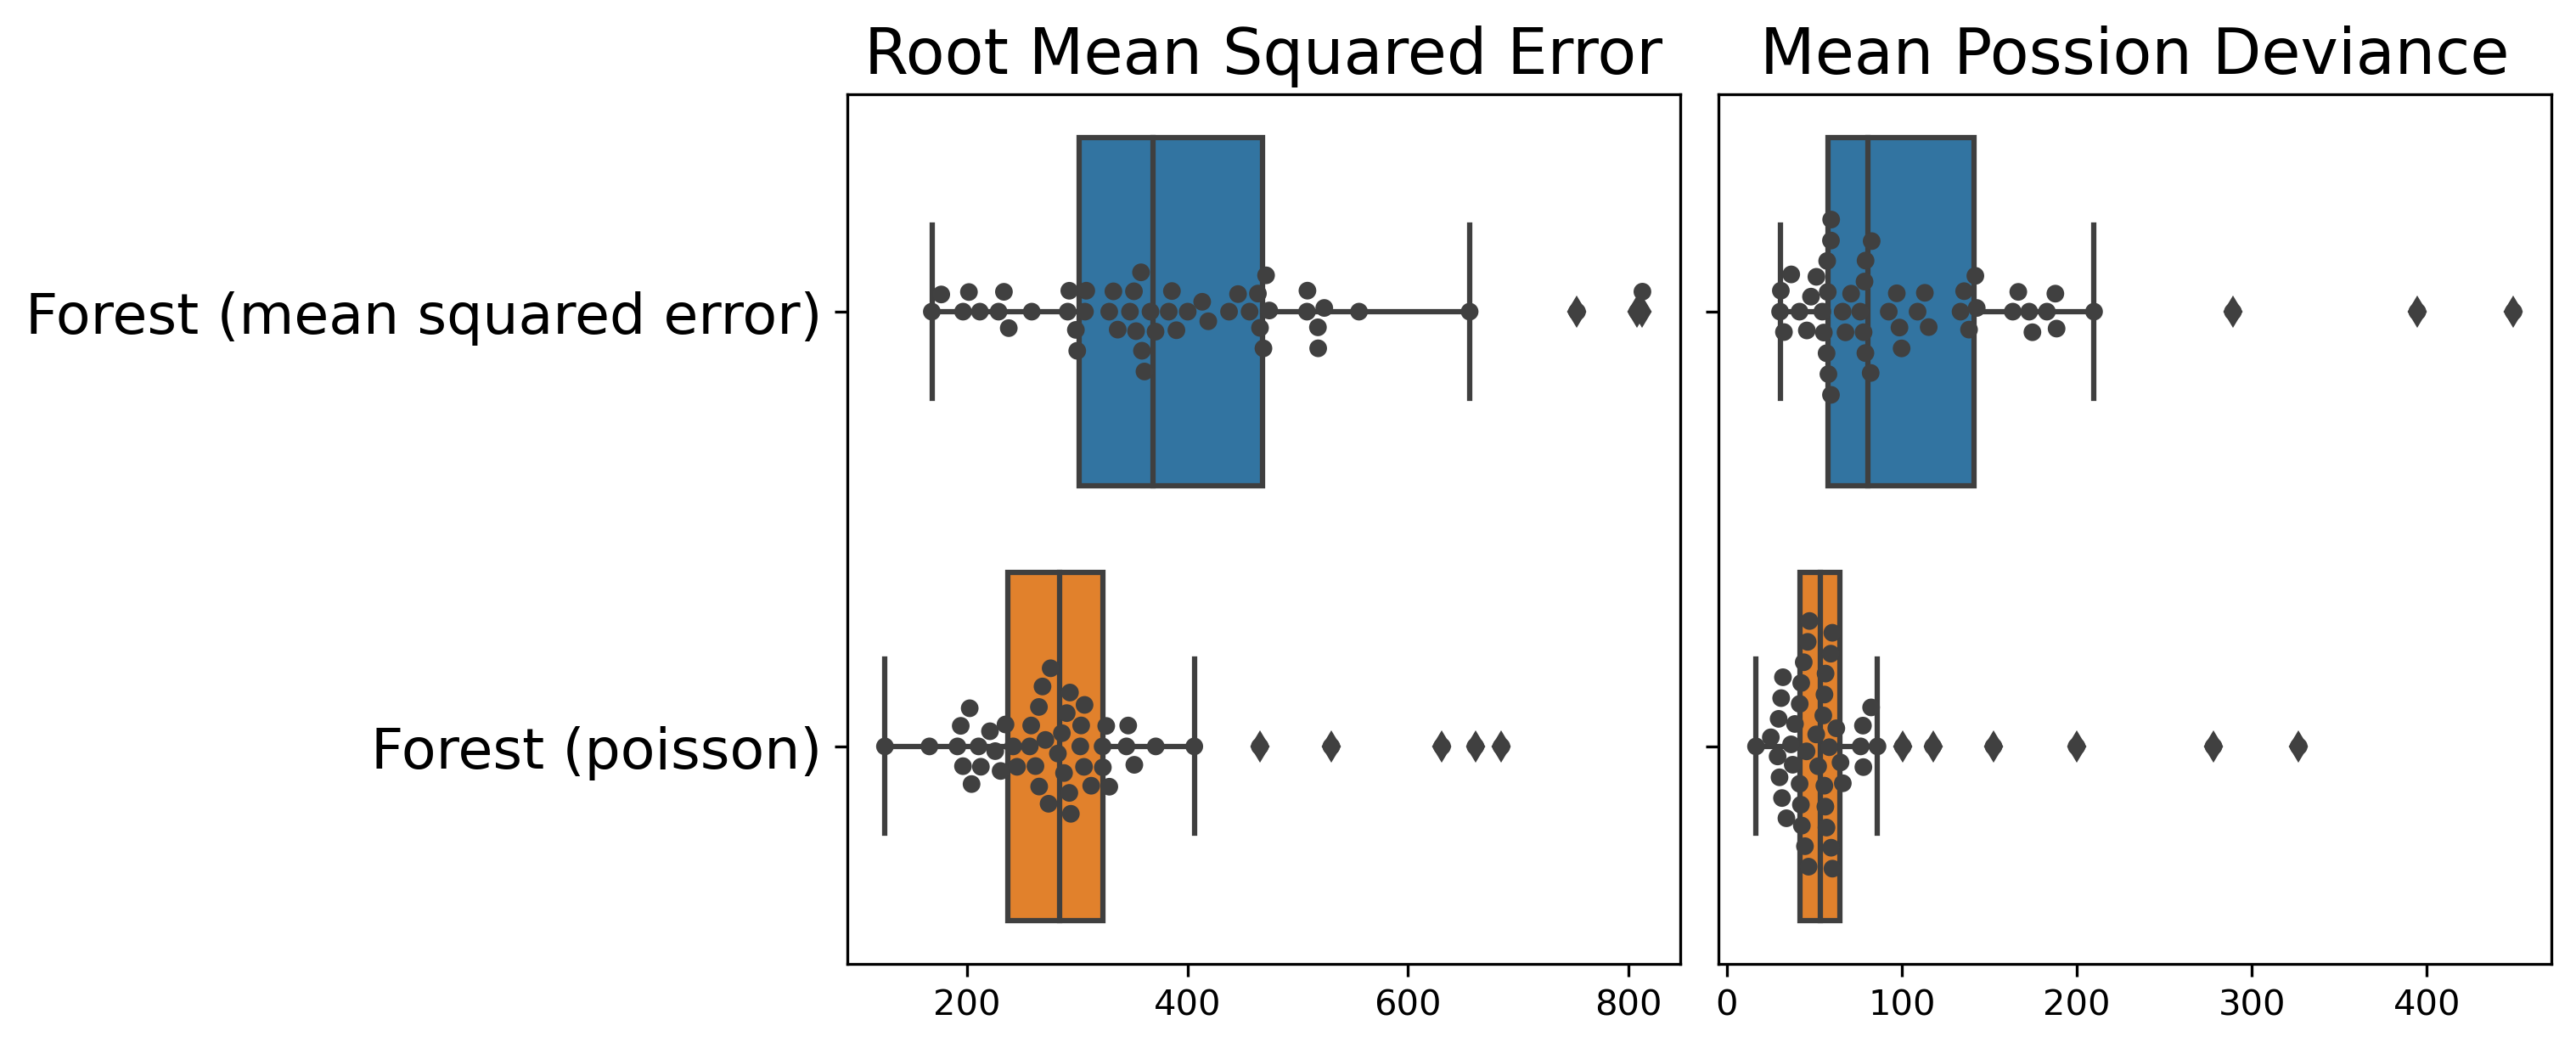

In [44]:
fig = plot_results(rf_results, rf_poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "forest_metrics.svg")

## Evaluating Random Forest

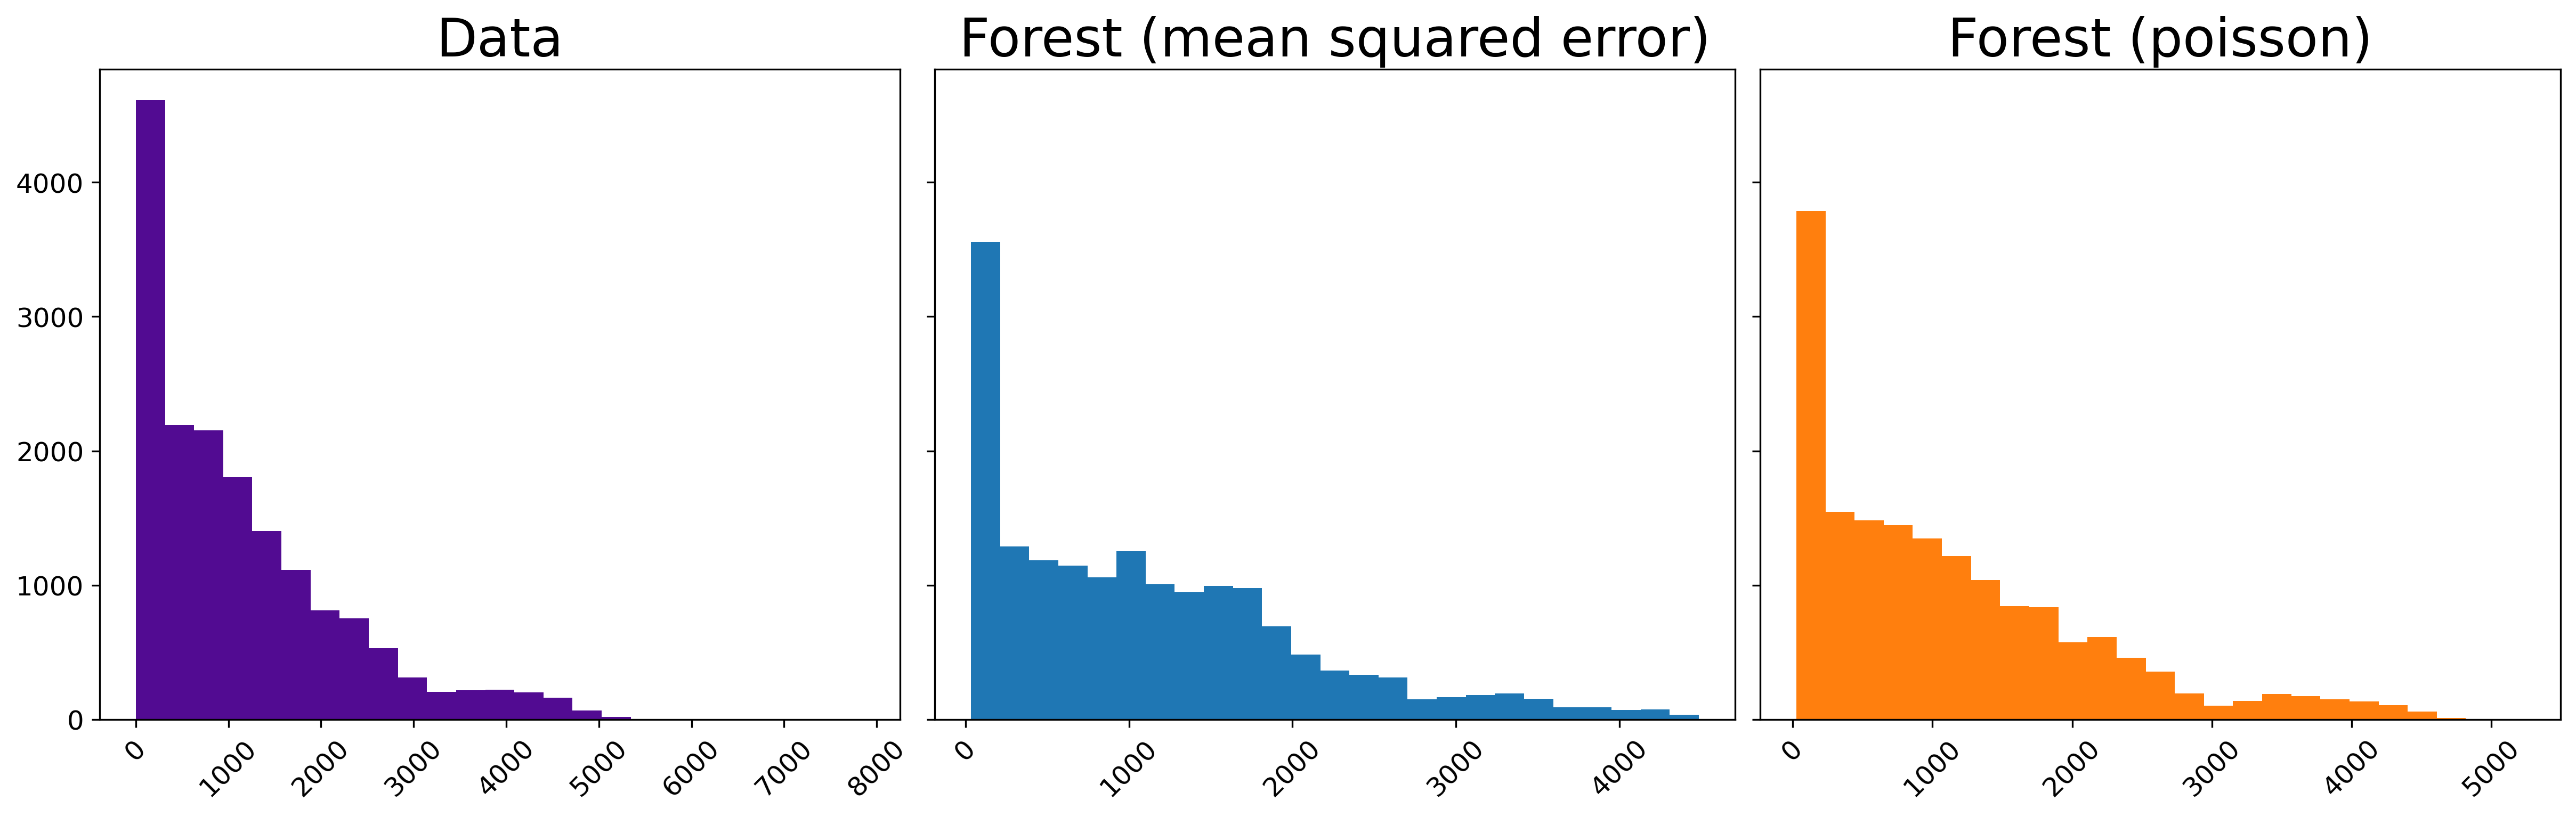

In [45]:
fig = plot_distribution(rf_results, rf_poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "forest_dist.svg")

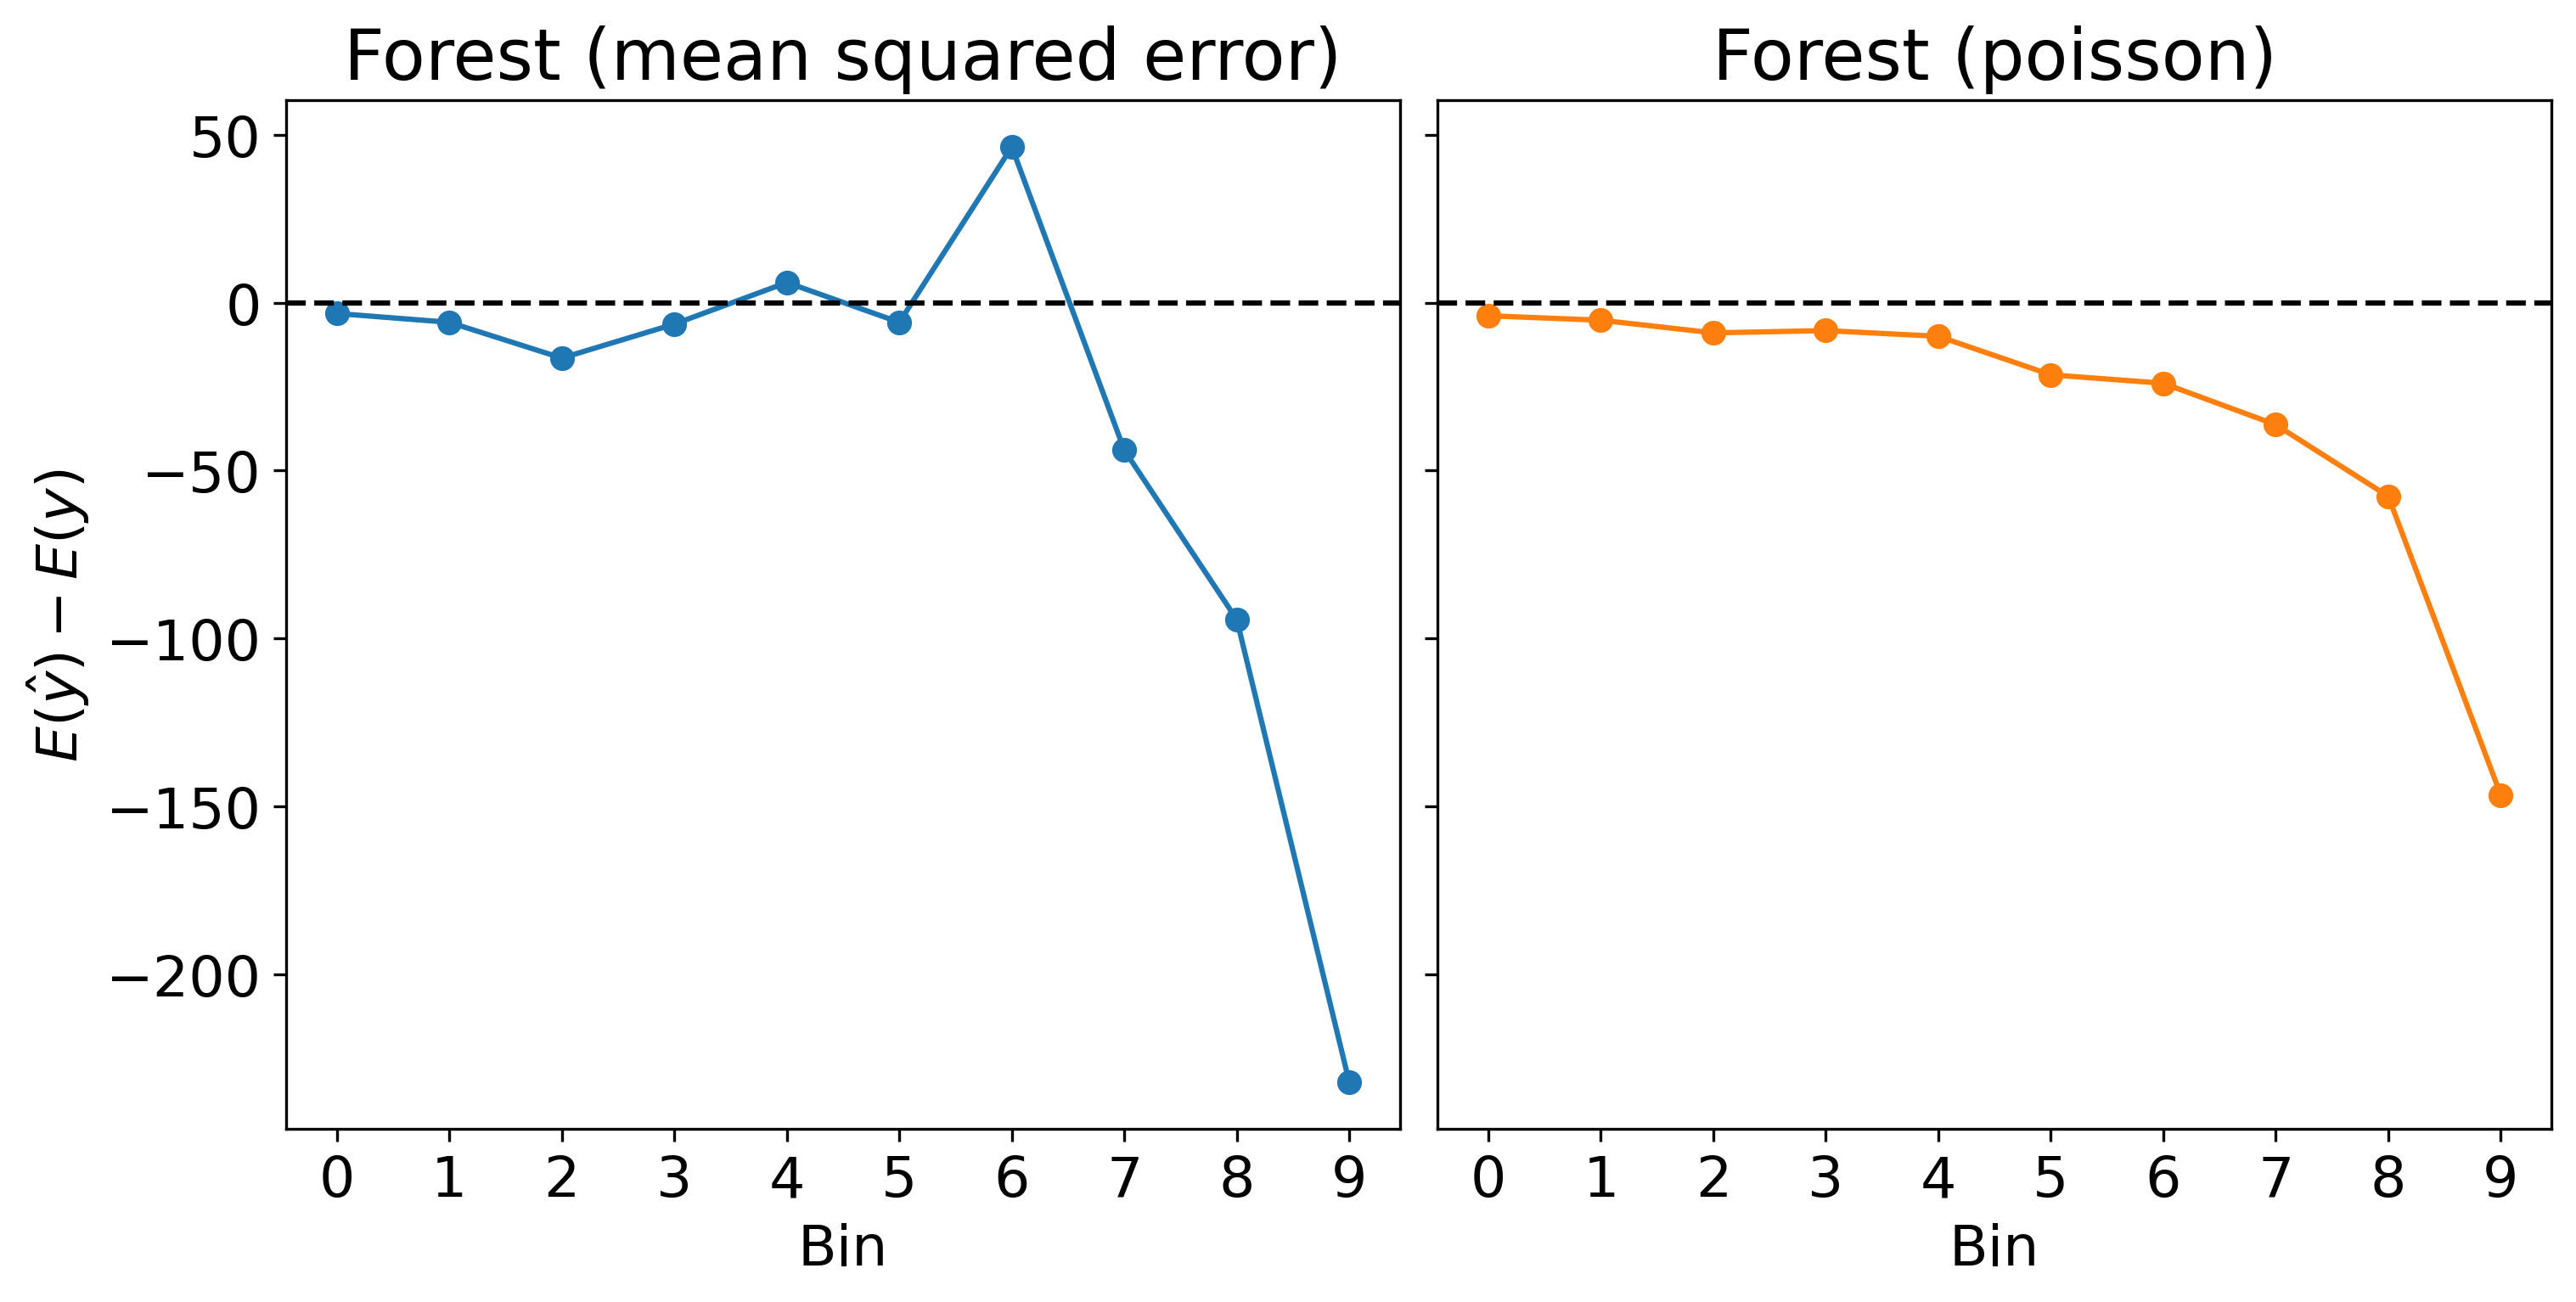

In [46]:
fig = plot_calibration(rf_results, rf_poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "forest_calib.svg")

## HistGradientBoosting

In [47]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [48]:
hist = HistGradientBoostingRegressor(random_state=0, max_depth=4)

In [49]:
hist_results = evaluate_model(hist, "Hist (mean squared error)", n_jobs=8)

In [50]:
hist_results["mean_possion_devianace_mean"]

77.21187718193396

In [51]:
# 60 max_depth=None
# 6 max_depth=5
# 76 max_depth=4

In [52]:
get_predictions_all_splits(hist_results)

## HistGradientBoosting Poisson

In [53]:
hist_poisson = HistGradientBoostingRegressor(random_state=0, loss="poisson", max_depth=4)

In [54]:
hist_poisson_results = evaluate_model(hist_poisson, "Hist (poisson)", n_jobs=8)

In [55]:
hist_poisson_results["mean_possion_devianace_mean"]

60.37823735731598

In [56]:
get_predictions_all_splits(hist_poisson_results)

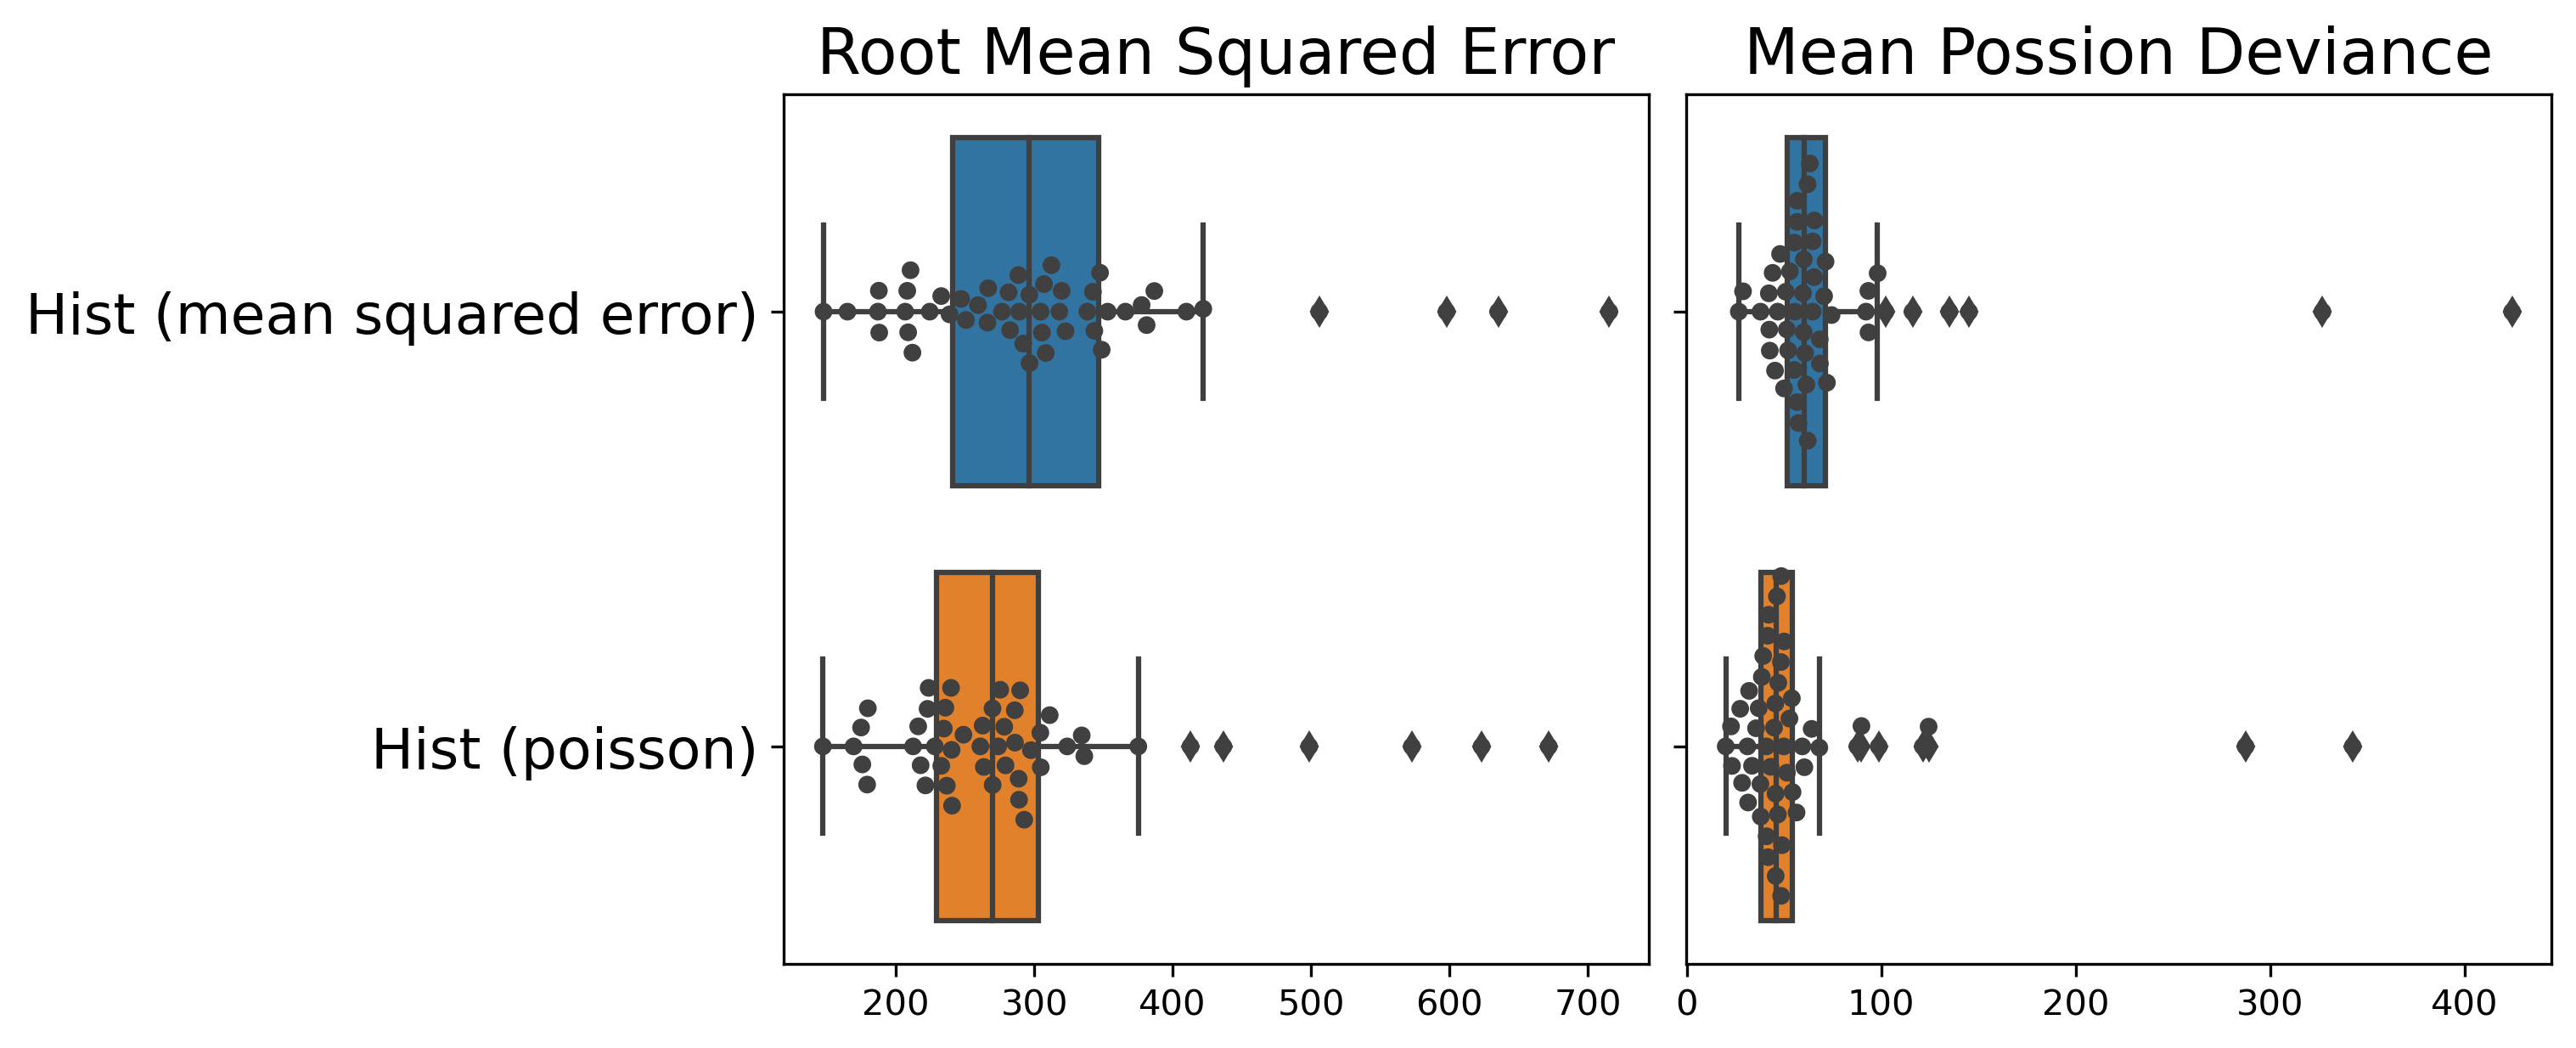

In [57]:
fig = plot_results(hist_results, hist_poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "hist_metrics.svg")

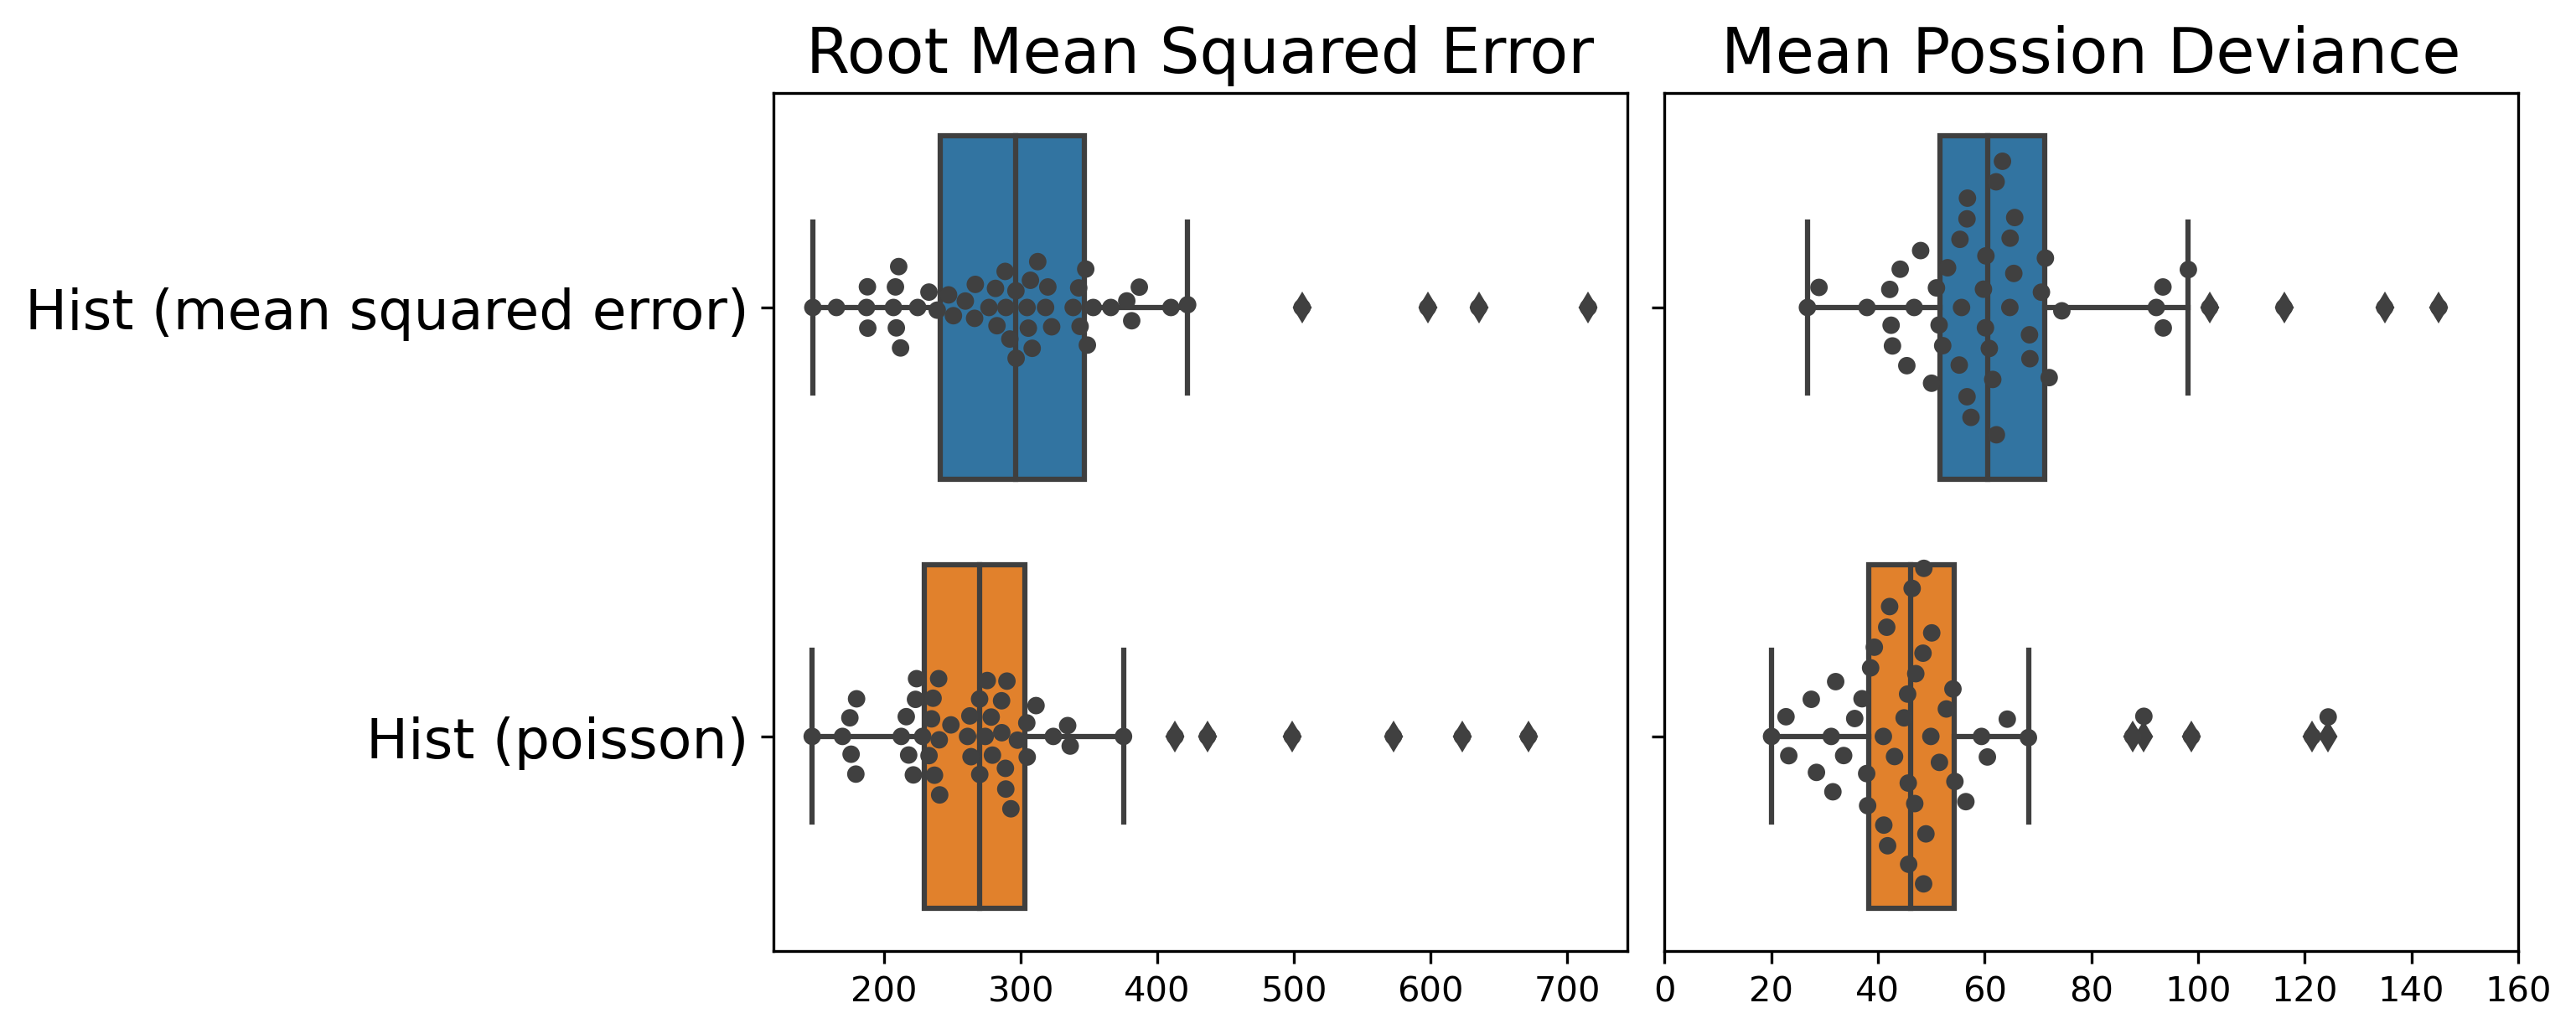

In [58]:
fig = plot_results(hist_results, hist_poisson_results)
fig.axes[1].set_xlim((0, 160))
if EXPORT_IMAGES:
    fig.savefig(images / "hist_metrics_zoomed.svg")

## Evaluting HistGradientBoosting

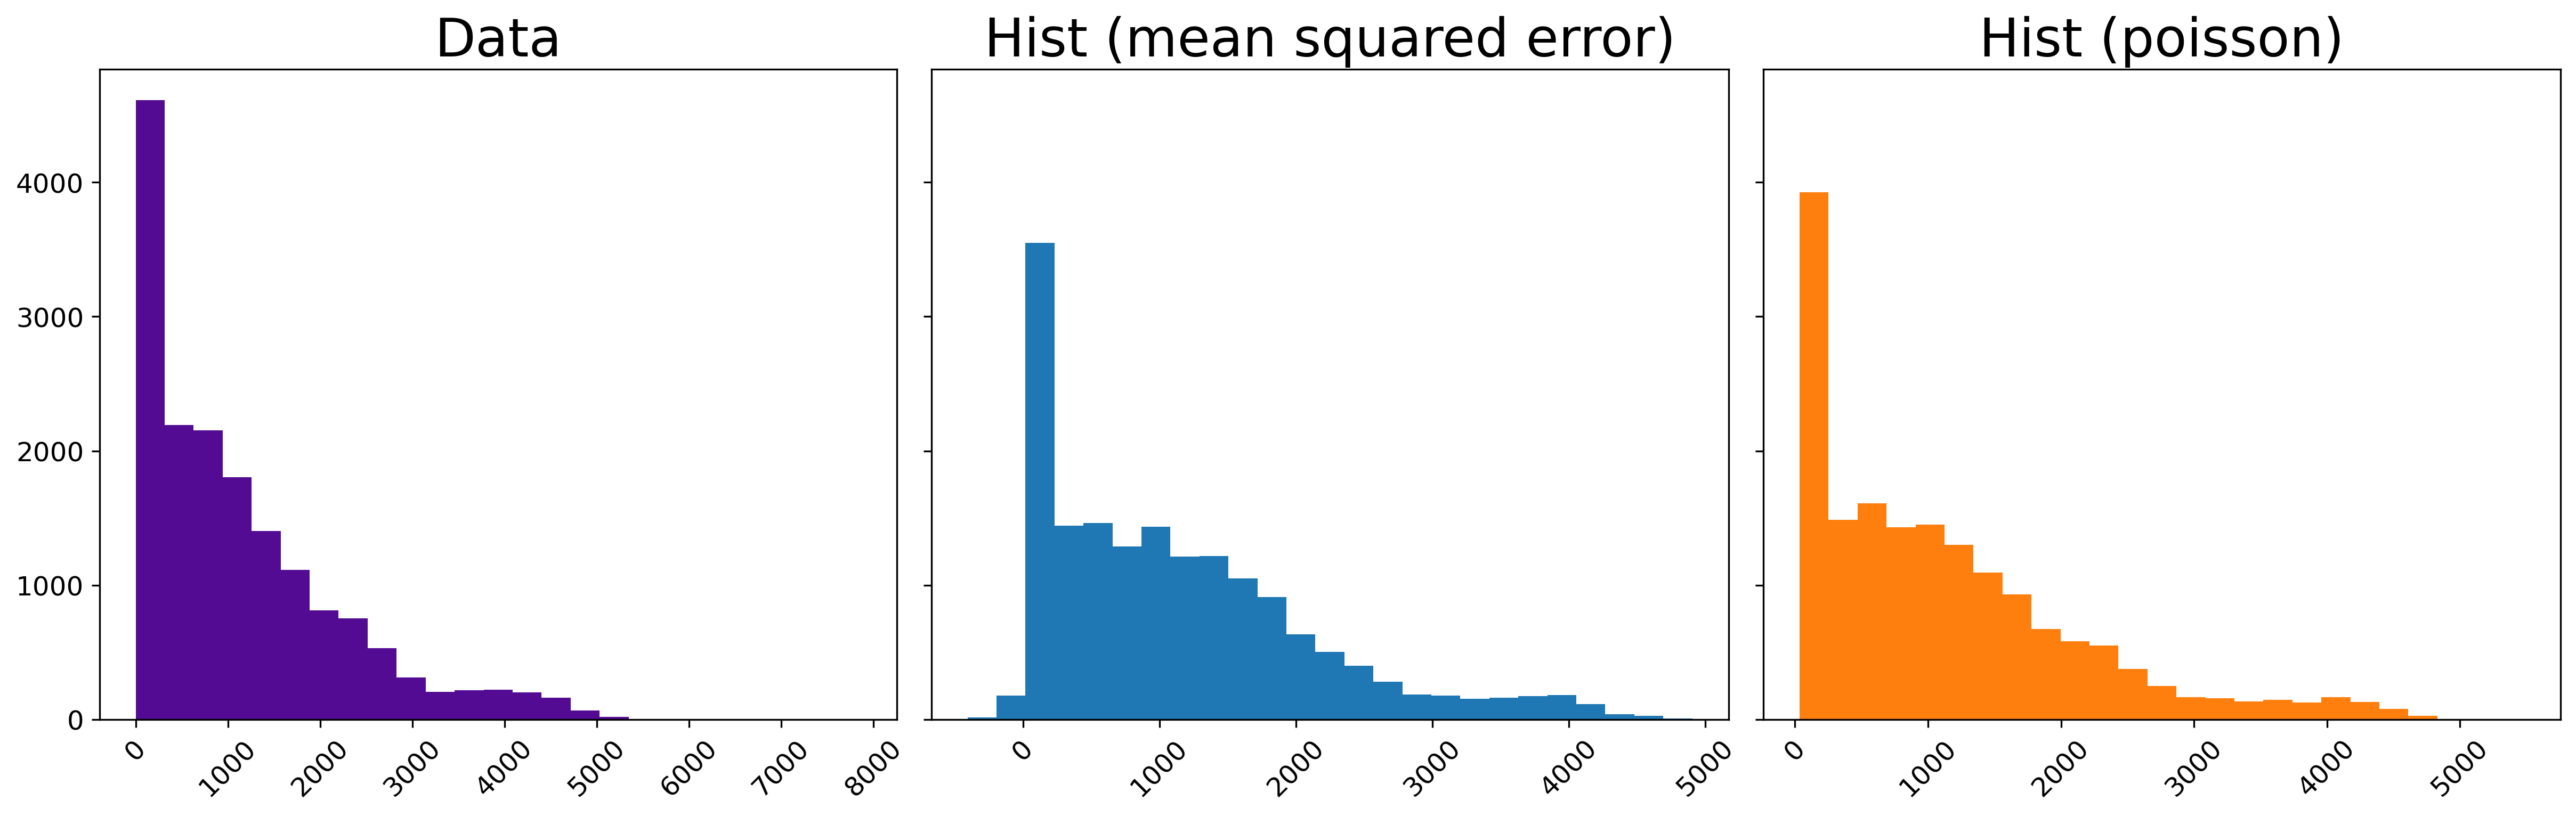

In [59]:
fig = plot_distribution(hist_results, hist_poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "hist_dist.svg")

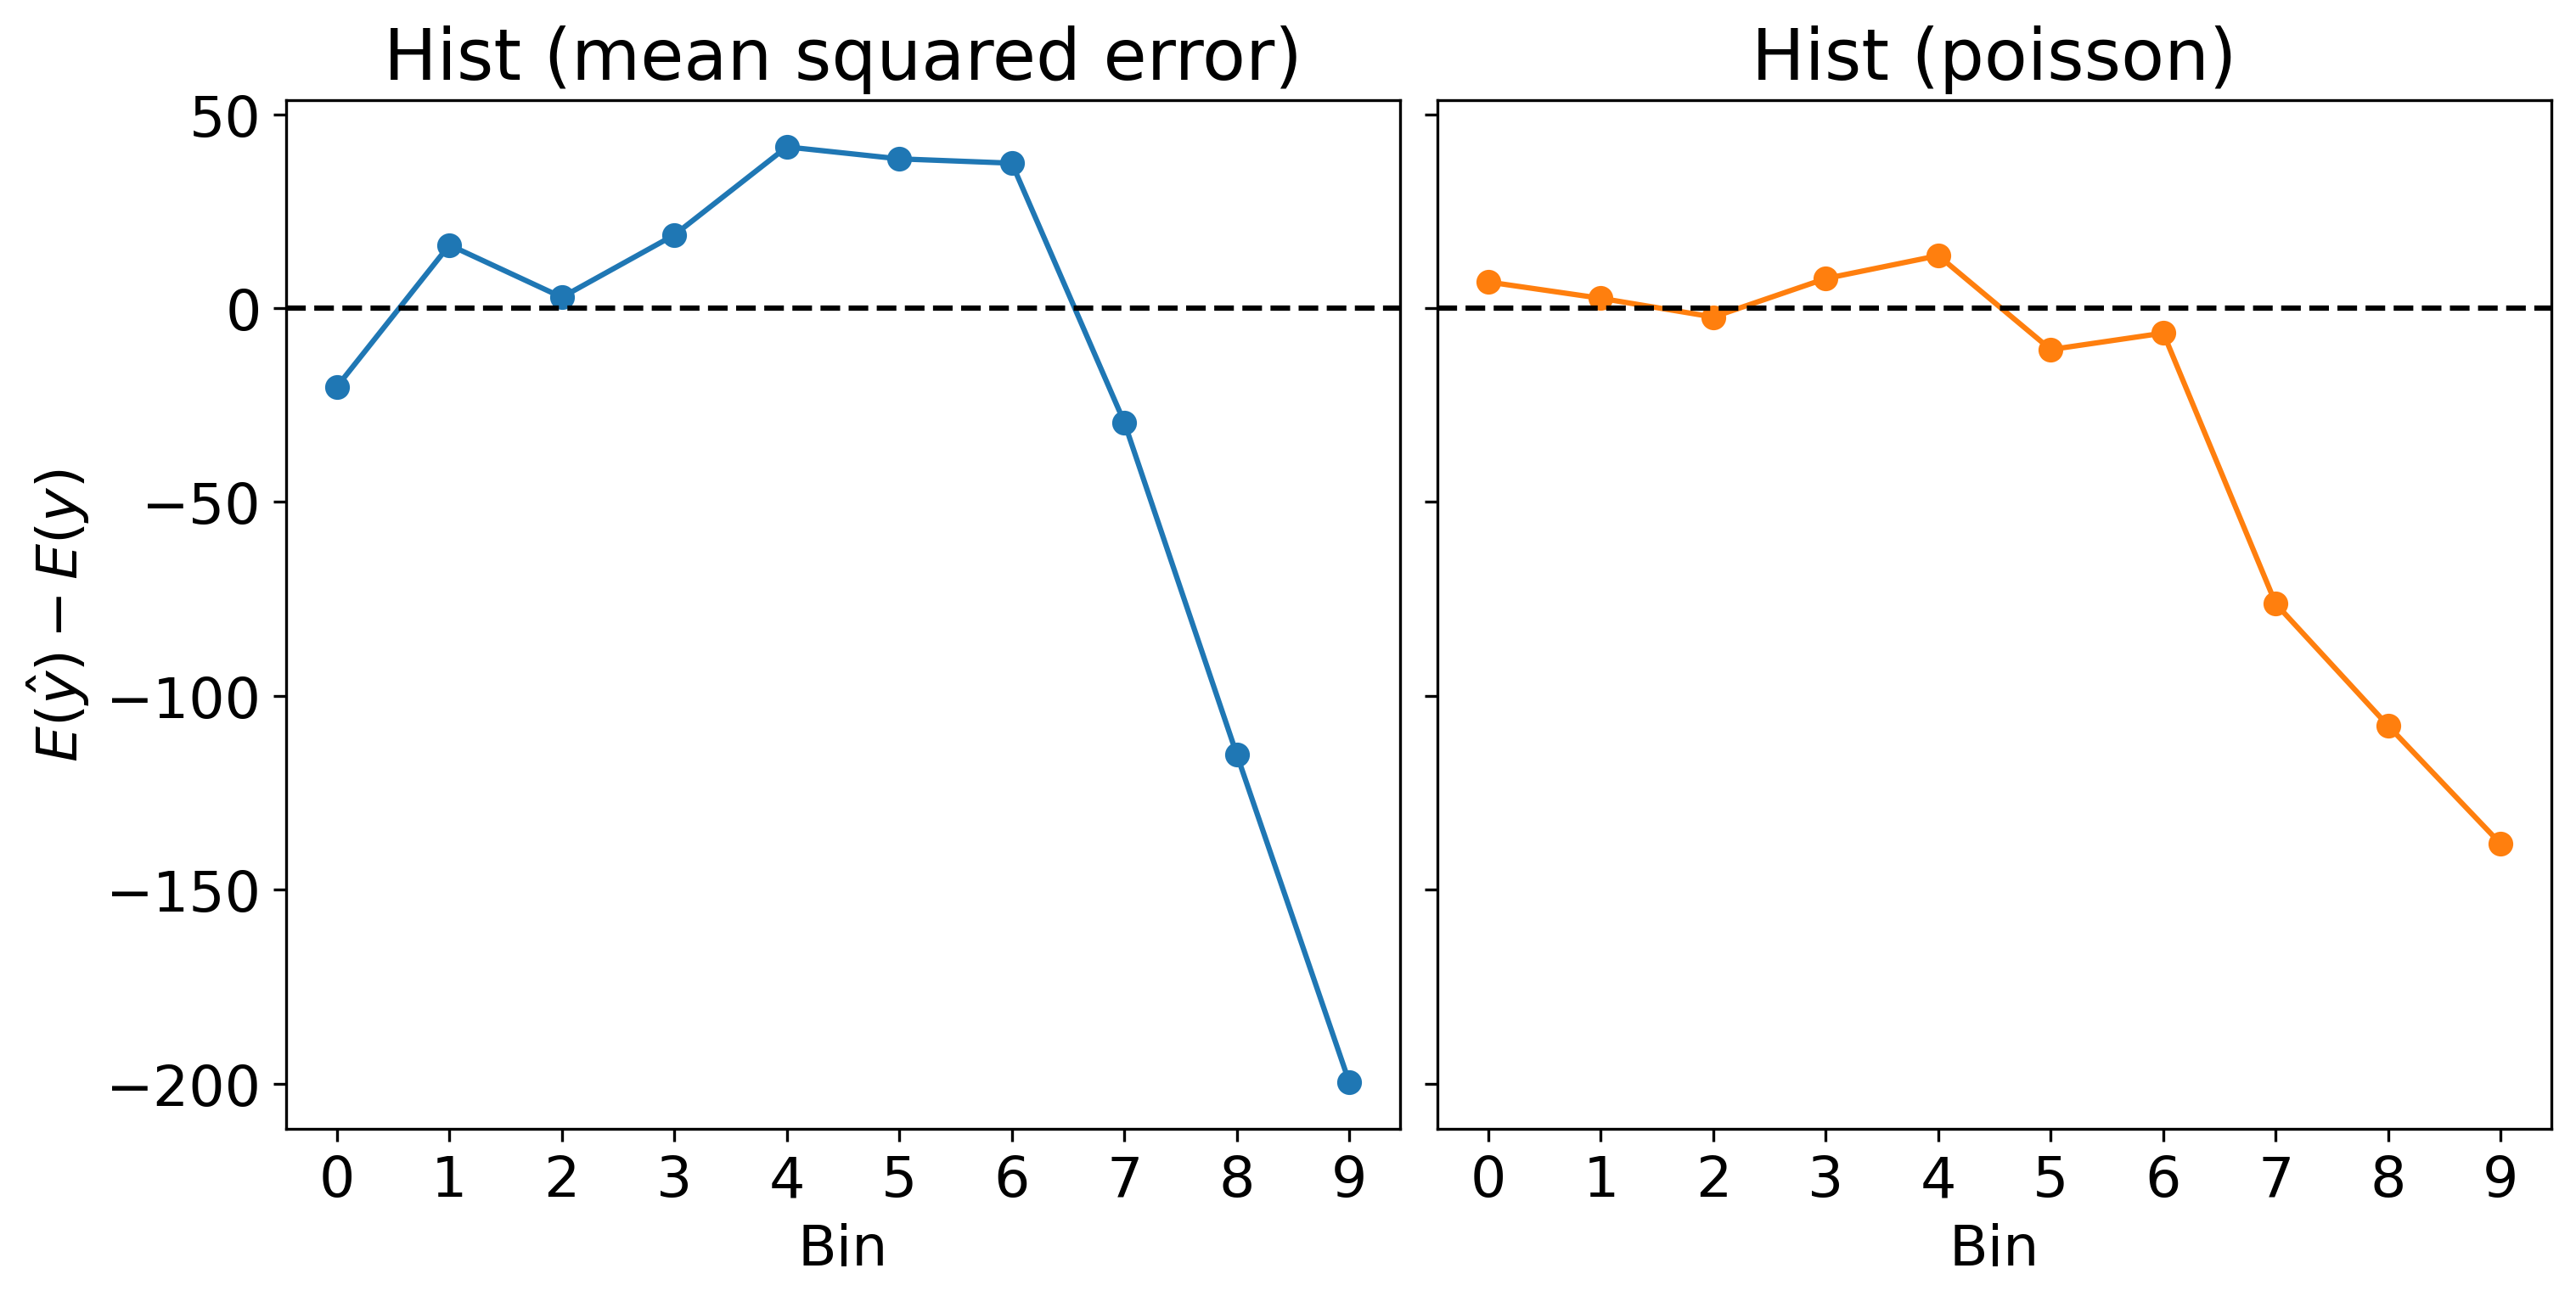

In [60]:
fig = plot_calibration(hist_results, hist_poisson_results)
if EXPORT_IMAGES:
    fig.savefig(images / "hist_calib.svg")

### Prediction for a test set

In [61]:
splits = list(cv.split(X))

In [62]:
train_idx, test_idx = splits[-1]

In [63]:
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], np.asarray(y.iloc[test_idx])

In [64]:
poisson.fit(X_train, y_train)
poisson_pred = poisson.predict(X_test)
rf_poisson.fit(X_train, y_train)
rf_pred = rf_poisson.predict(X_test)
hist_poisson.fit(X_train, y_train)
hist_pred = hist_poisson.predict(X_test)

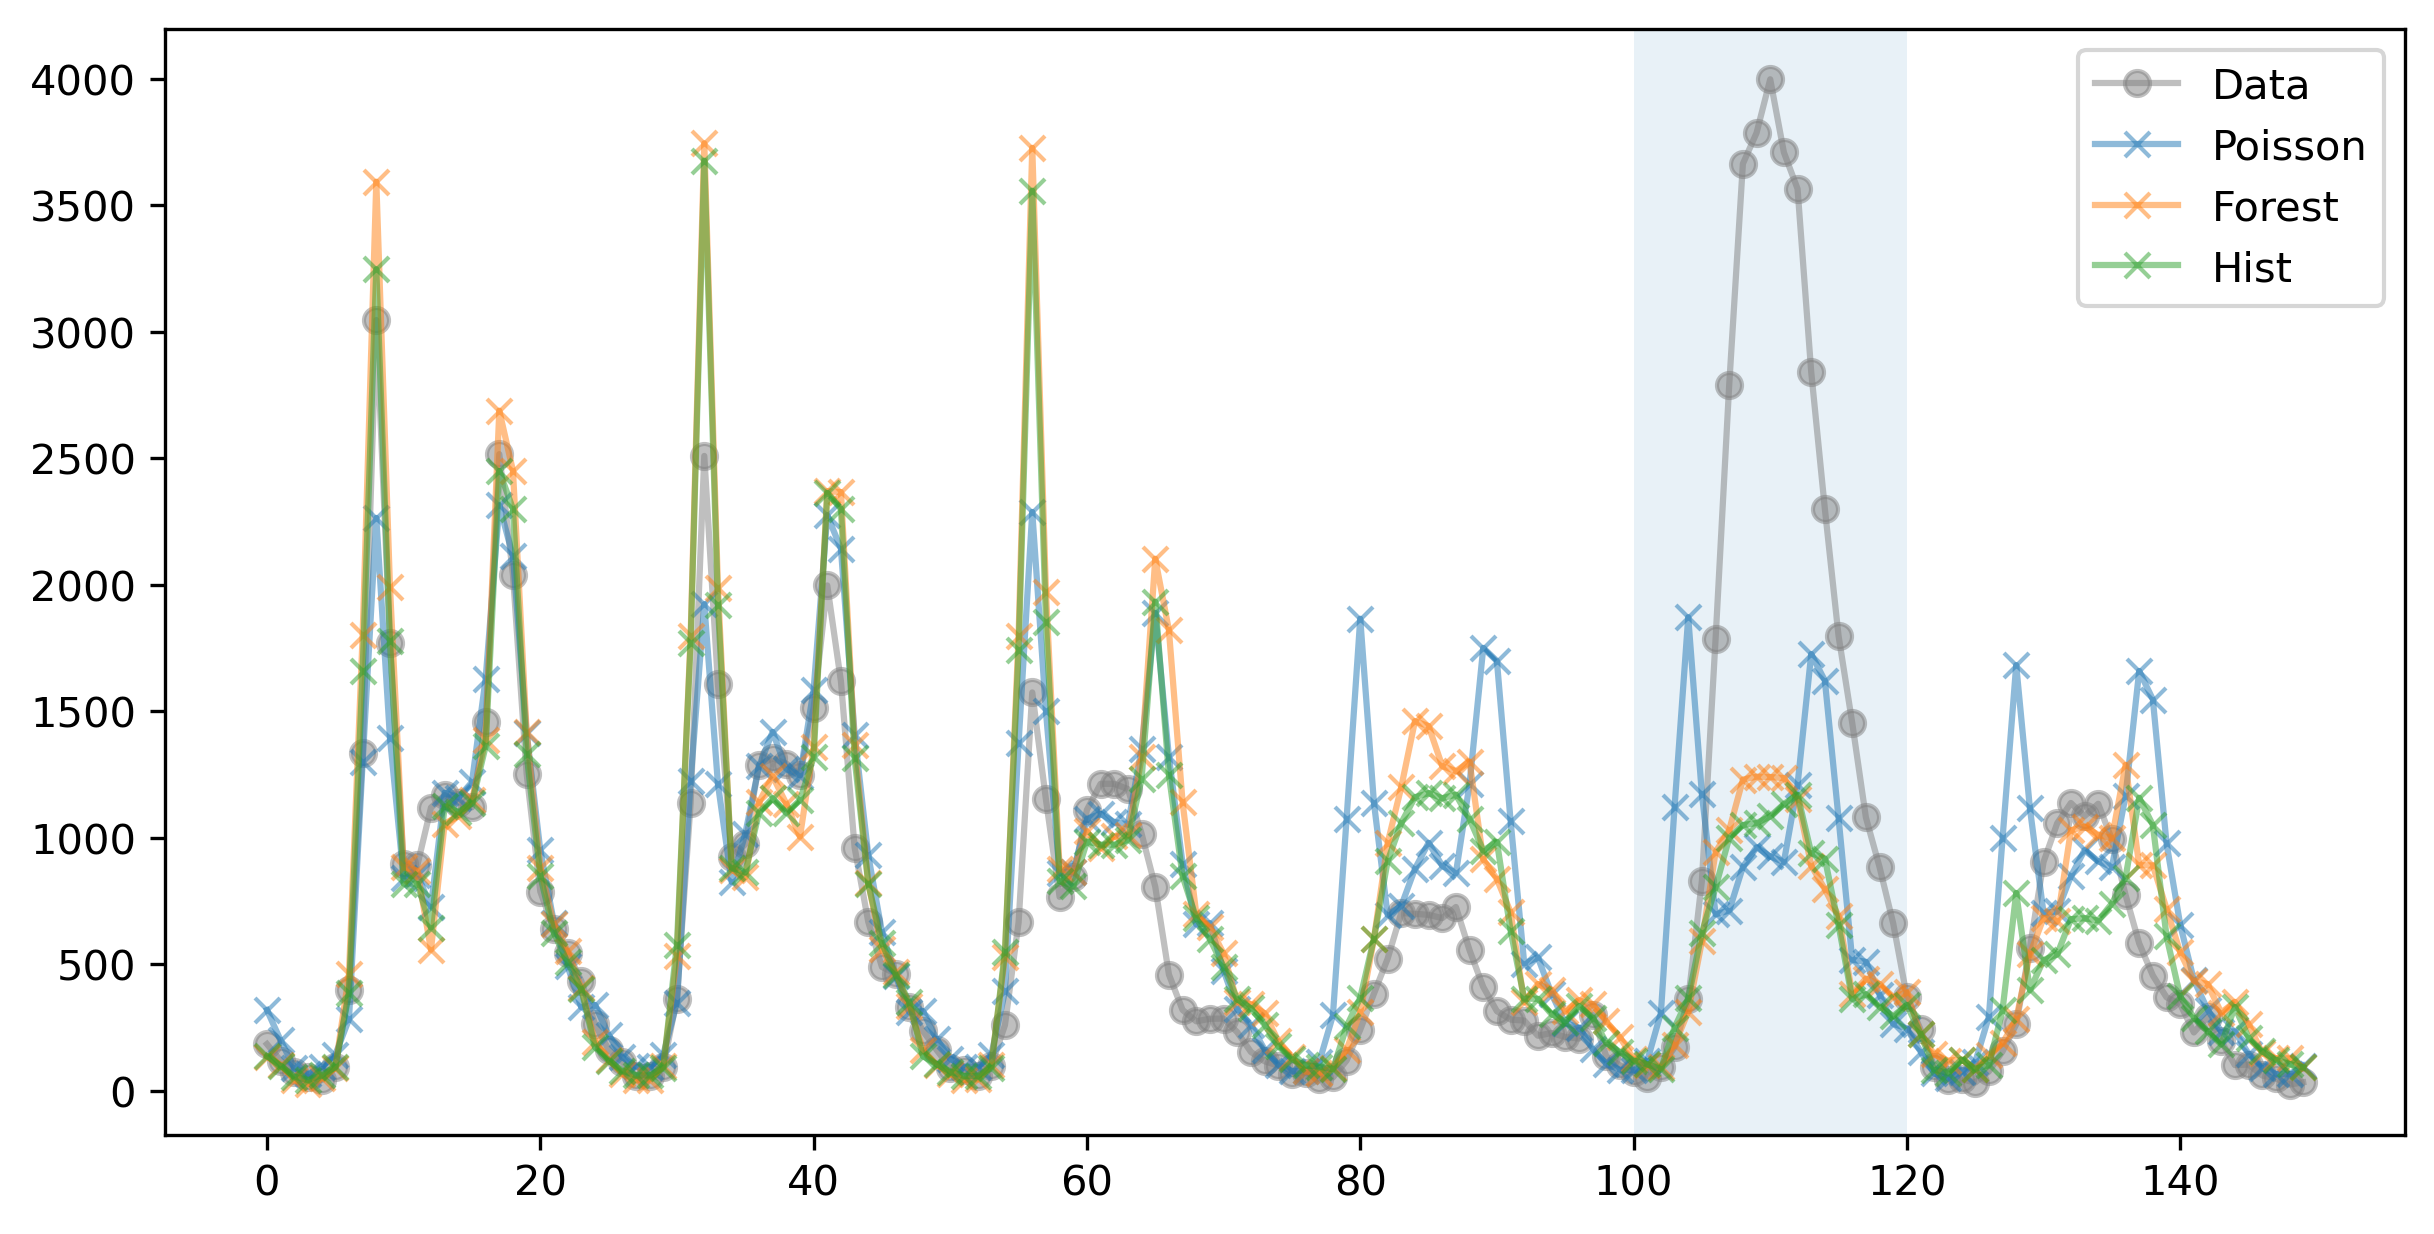

In [65]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(8, 4), dpi=300, constrained_layout=True)
ax.plot(y_test[:150], "o-", color="gray", alpha=0.5, label="Data")
ax.plot(poisson_pred[:150], "x-", alpha=0.5, label="Poisson")
ax.plot(rf_pred[:150], "x-", alpha=0.5, label="Forest")
ax.plot(hist_pred[:150], "x-", alpha=0.5, label="Hist")
ax.legend()
y_lim = ax.get_ylim()
rect = Rectangle((100, y_lim[0]), 20, y_lim[1] - y_lim[0], alpha=0.1)
ax.add_patch(rect)
if EXPORT_IMAGES:
    fig.savefig(images / "prediction.svg")

## Zero inflated

In [66]:
from sklego.meta import ZeroInflatedRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

In [67]:
y_zero_inflated = y.copy()
y_zero_inflated[y < 500] = 0

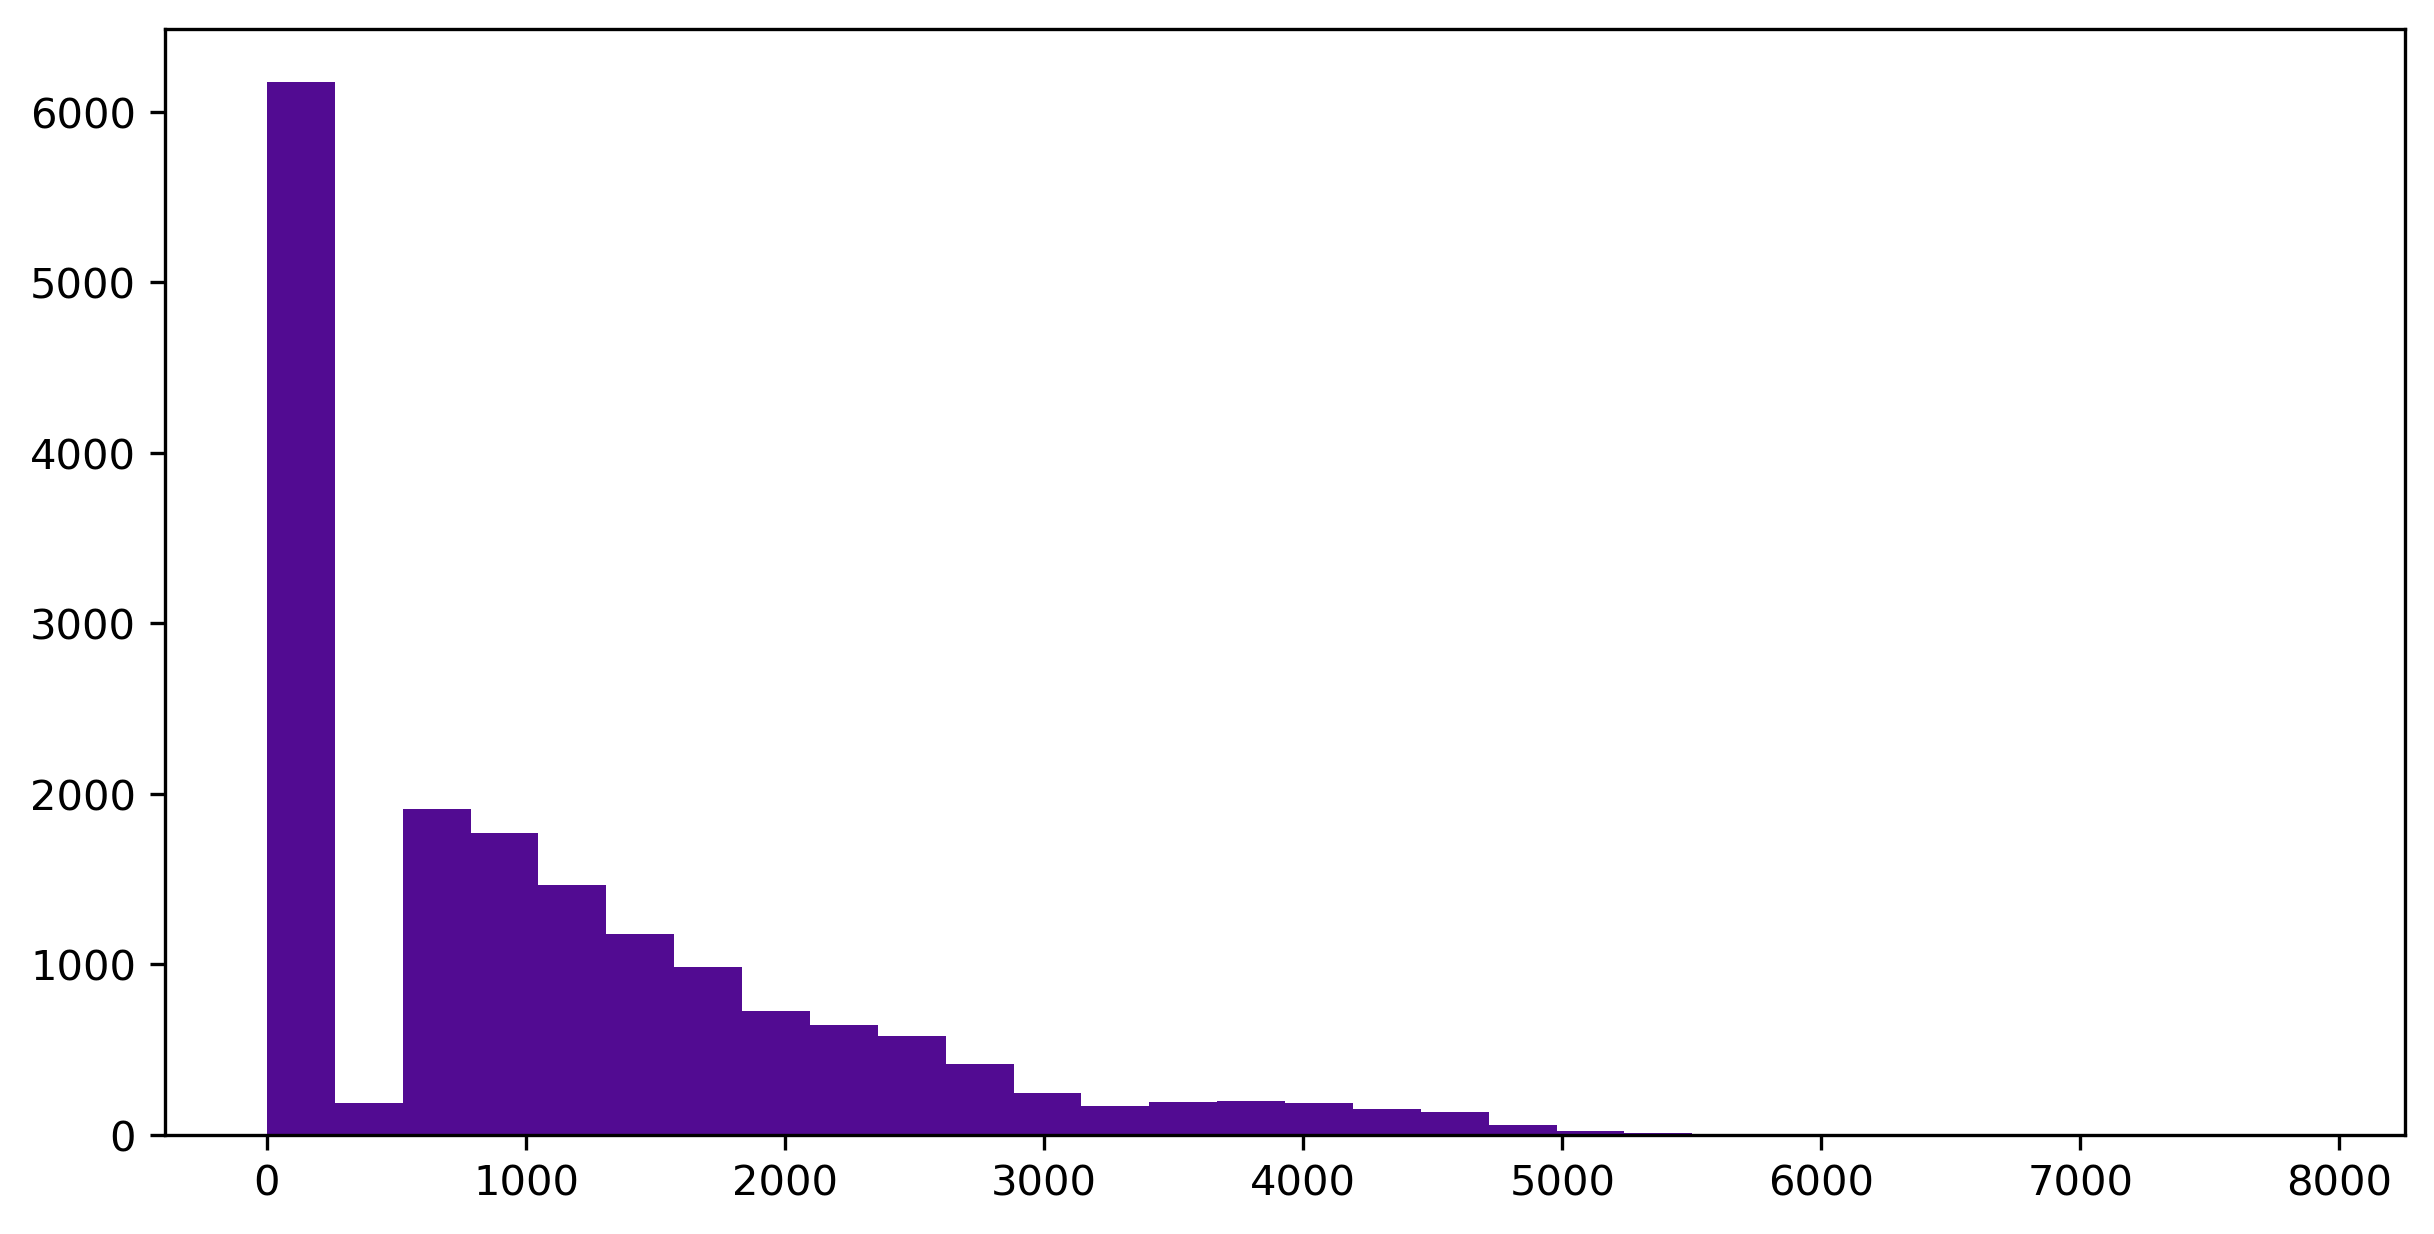

In [68]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300, constrained_layout=True)
_ = ax.hist(y_zero_inflated, bins=30, color=purple)
if EXPORT_IMAGES:
    fig.savefig(images / "zero_inflated.svg")

In [69]:
poisson_zero =  ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=0),
    regressor=HistGradientBoostingRegressor(loss="poisson")
)

In [70]:
poisson_zero.fit(X, y_zero_inflated)

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=0),
                      regressor=HistGradientBoostingRegressor(loss='poisson'))

## Extra

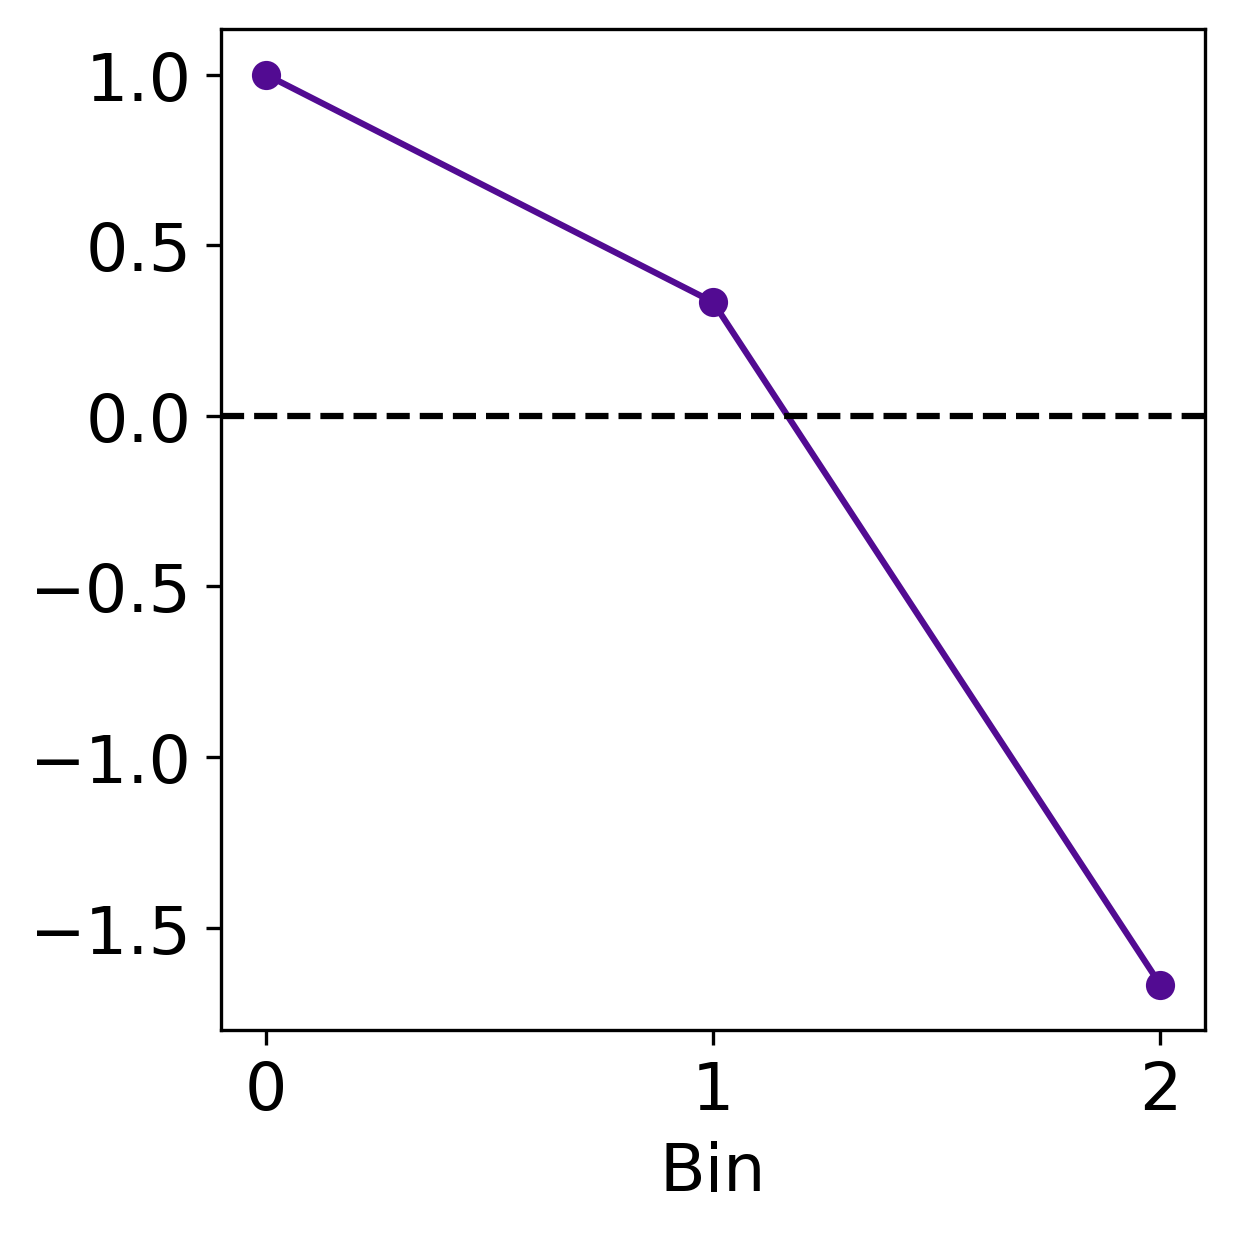

In [71]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300, constrained_layout=True)
plot_single_calibration(np.asarray([2, 6, 10, 1, 6, 1, 14, 10, 5]), np.asarray([4, 6, 9, 2, 5, 1, 12, 8, 7]), "", ax=ax, color=purple, n_bins=3)
if EXPORT_IMAGES:
    fig.savefig(images/ "example_calib.svg")

## Periodic spline features

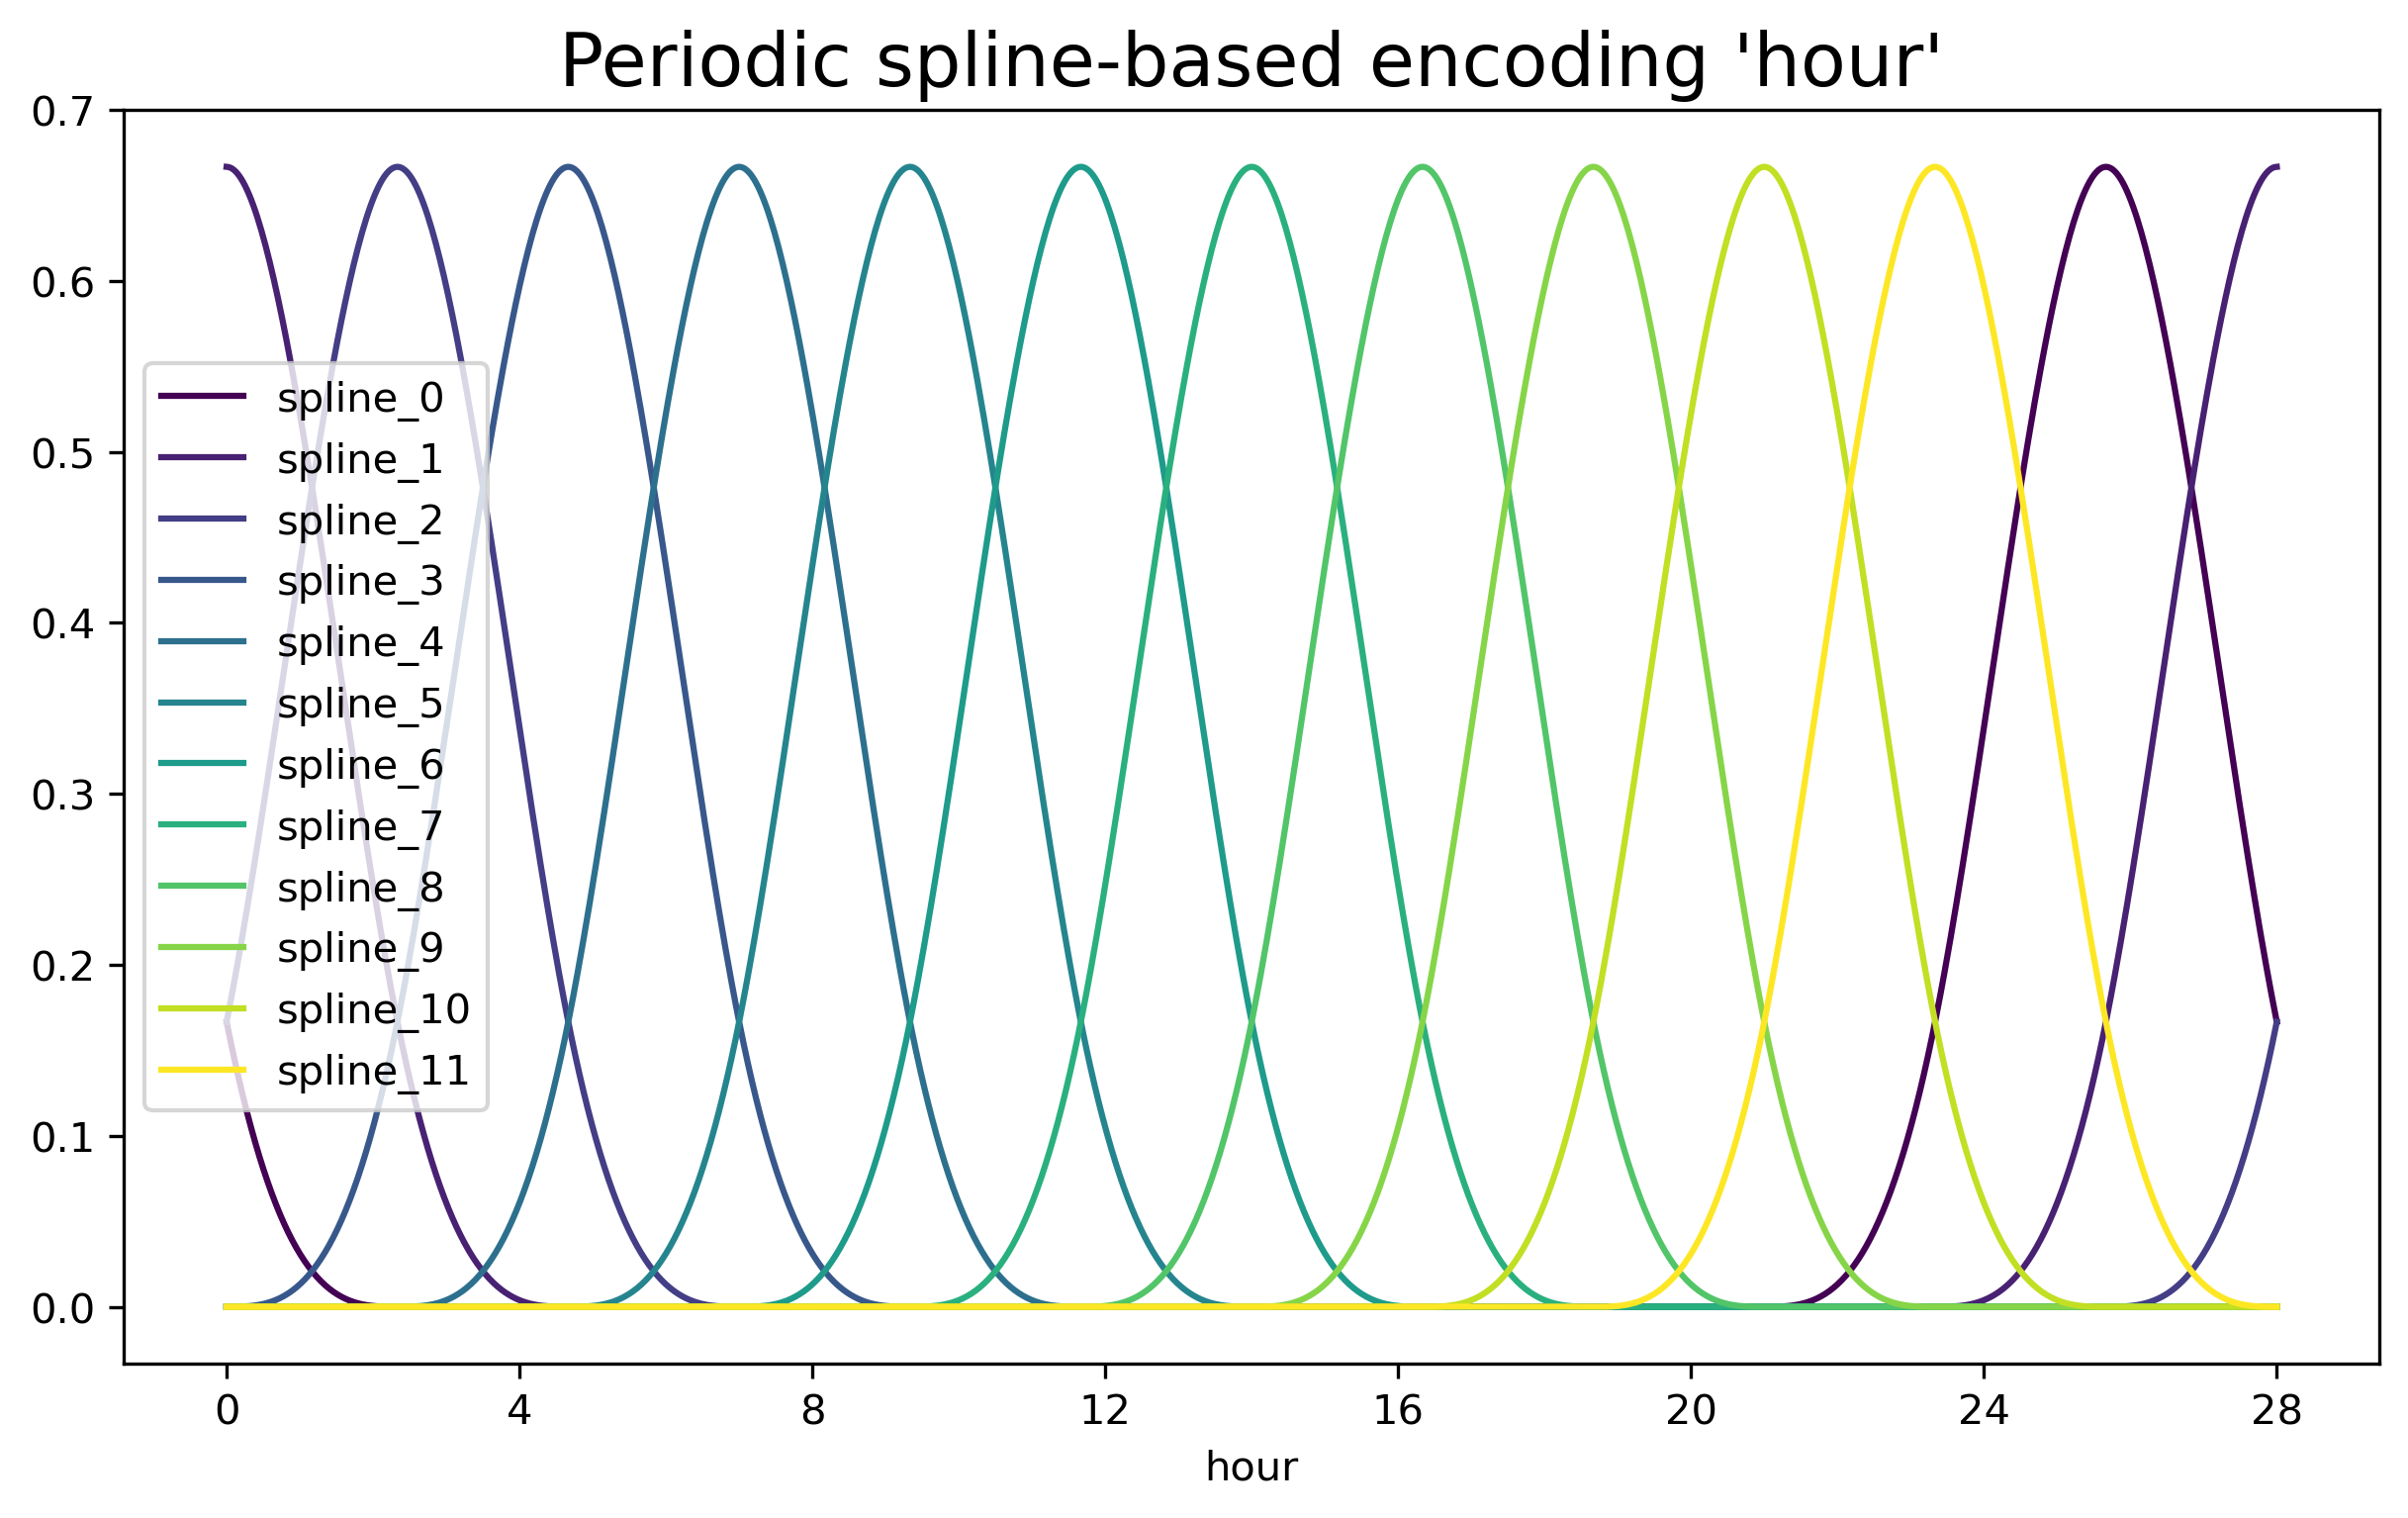

In [72]:
hour_df = pd.DataFrame(
    np.linspace(0, 28, 1000).reshape(-1, 1),
    columns=["hour"],
)
splines = SplineTransformer(n_knots=13, knots="uniform", extrapolation="periodic").fit_transform(hour_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
fig, ax = plt.subplots(figsize=(8, 5), dpi=300, constrained_layout=True)
pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.viridis, ax=ax)
ax.set_xticks(range(0, 29, 4))
ax.set_title("Periodic spline-based encoding 'hour'", fontsize=18)
ax.legend(loc="center left")
if EXPORT_IMAGES:
    fig.savefig(images / "periodic_spline_features.svg")